In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_utils import *
from eda_utils import *
from train_utils import *
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import pickle
import os

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Preprocessing

## Dataset creation

In [3]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

In [4]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

## Splitting to test temporarily & Extracting probe's test data

In [5]:
biomass_test = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] >= 3)]
biomass_val = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] < 3)]
biomass_train = biomass_by_week_year_group[(~biomass_by_week_year_group.index.isin(biomass_test.index)) & (~biomass_by_week_year_group.index.isin(biomass_val.index))]

fp_test = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] >= 3)]
fp_val = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] < 3)]
fp_train = fp_df[(~fp_df.index.isin(fp_test.index)) & (~fp_df.index.isin(fp_val.index))]

merged_train = merge_fp_biomass_df(fp_train, biomass_train, is_train=True) # Merging fully
merged_val = merge_fp_biomass_df(fp_val, biomass_val, is_train=False) # Merging fully
merged_test = merge_fp_biomass_df(fp_test, biomass_test, is_train=False) # Merging only closest records by depth

In [6]:
merged_train = merged_train.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_groups_map = {
    2: 'Bluegreen',
    3: 'Diatoms',
    4: 'Green Algae',
    6: 'Cryptophyta'
}

fluor_val_df = merged_val[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_val = merged_val.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_test_df = merged_test[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_test = merged_test.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

In [7]:
len(merged_train.sum_biomass_ug_ml.unique())

2043

In [8]:
biomass_estimation(merged_train)

In [9]:
len(merged_train.sum_biomass_ug_ml.unique())

55357

### Saving original train df for later tests

In [10]:
orig_merged_train = merged_train.copy()

In [11]:
orig_merged_train.loc[orig_merged_train['Depth'] >= 21, 'Depth'] = 21

# EDA and Cleaning

In [12]:
merged_train.shape

(55389, 18)

In [13]:
merged_train = merged_train[merged_train['sum_biomass_ug_ml'] >= 0]

In [14]:
merged_train.shape

(53332, 18)

In [15]:
merged_train.loc[merged_train['Depth'] >= 21, 'Depth'] = 21
merged_val.loc[merged_val['Depth'] >= 21, 'Depth'] = 21
merged_test.loc[merged_test['Depth'] >= 21, 'Depth'] = 21

In [16]:
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sample', 'yellow_sub', 'sum_biomass_ug_ml']

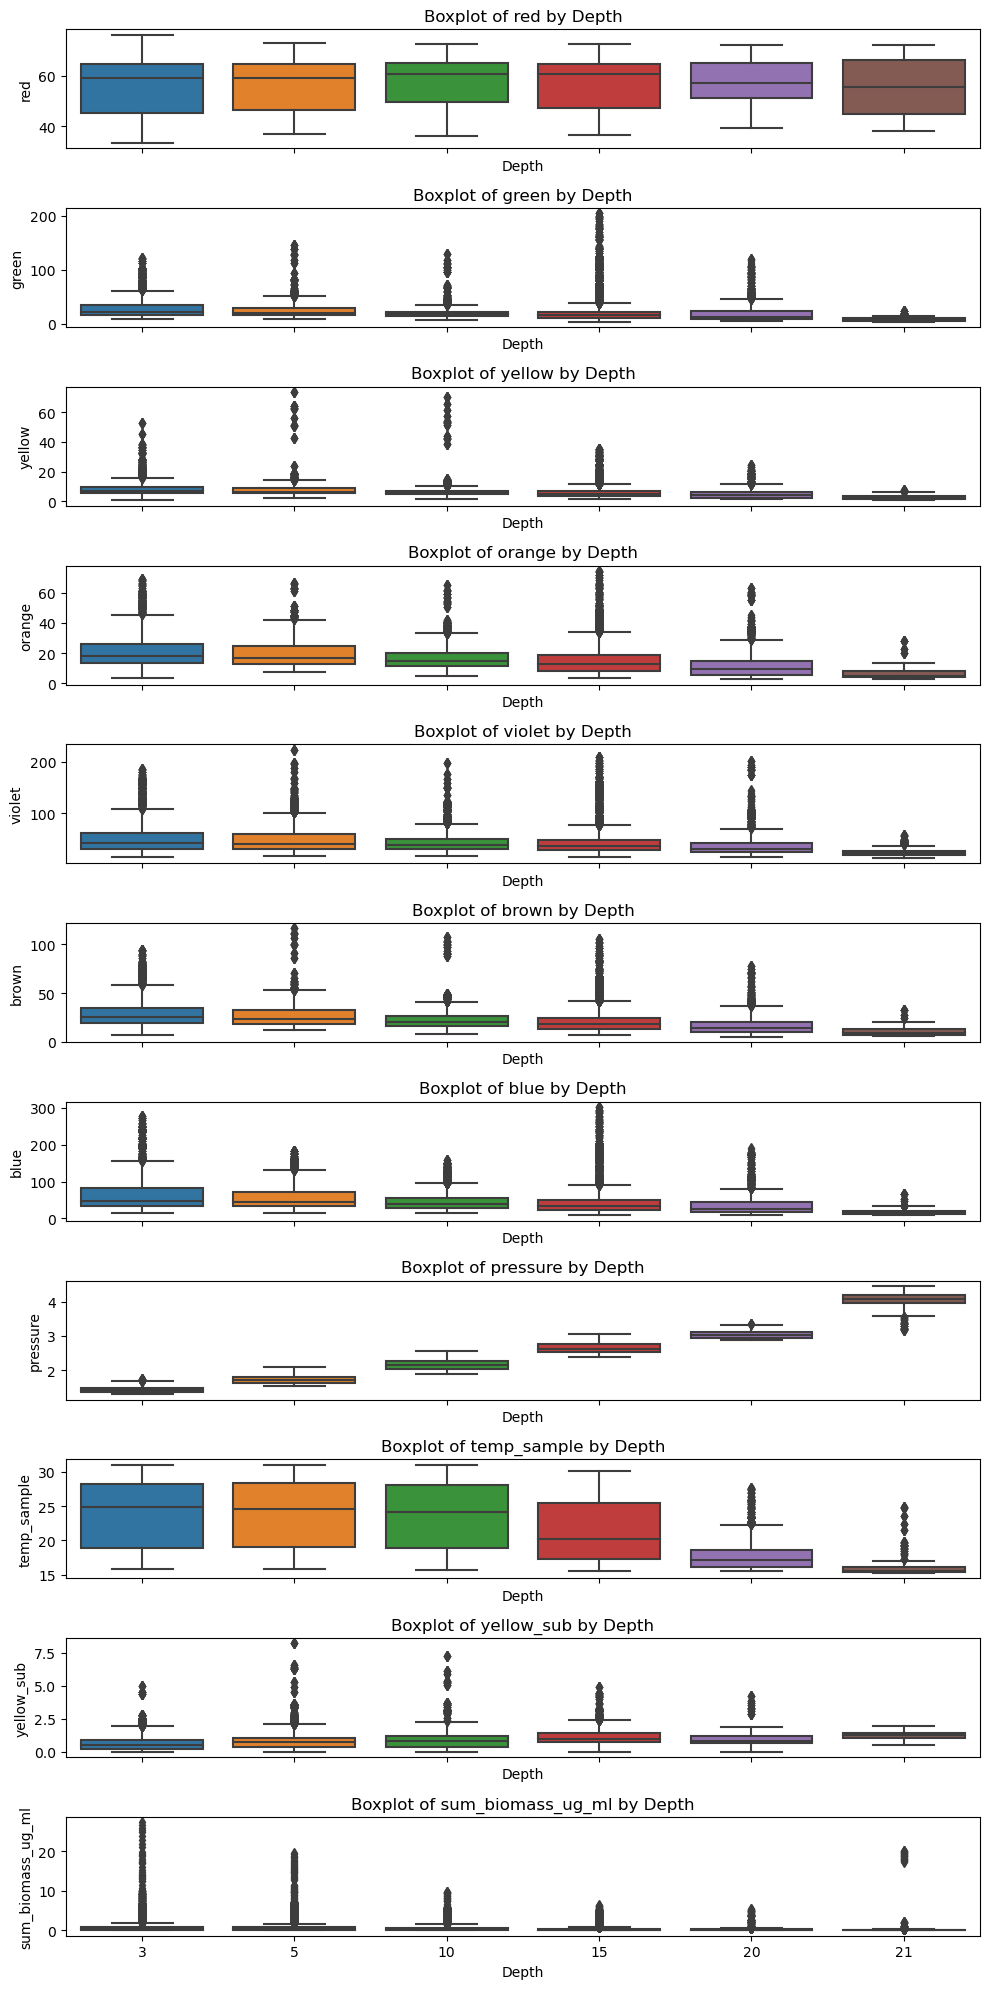

In [17]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

In [18]:
signals.remove('sum_biomass_ug_ml')
signals.remove('pressure')
signals.remove('temp_sample')
boundaries = {
    'red': {'lower_bound': 0, 'upper_bound': 120},
    'green': {'lower_bound': 0, 'upper_bound': 100},
    'yellow': {'lower_bound': 0, 'upper_bound': 40},
    'orange': {'lower_bound': 0, 'upper_bound': 60},
    'violet': {'lower_bound': 0, 'upper_bound': 150},
    'brown': {'lower_bound': 0, 'upper_bound': 80},
    'blue': {'lower_bound': 0, 'upper_bound': 220},
    'yellow_sub': {'lower_bound': 0, 'upper_bound': 7}
}

filter_signals_by_boundaries(merged_train, signals, boundaries)

In [19]:
merged_train.shape

(52368, 18)

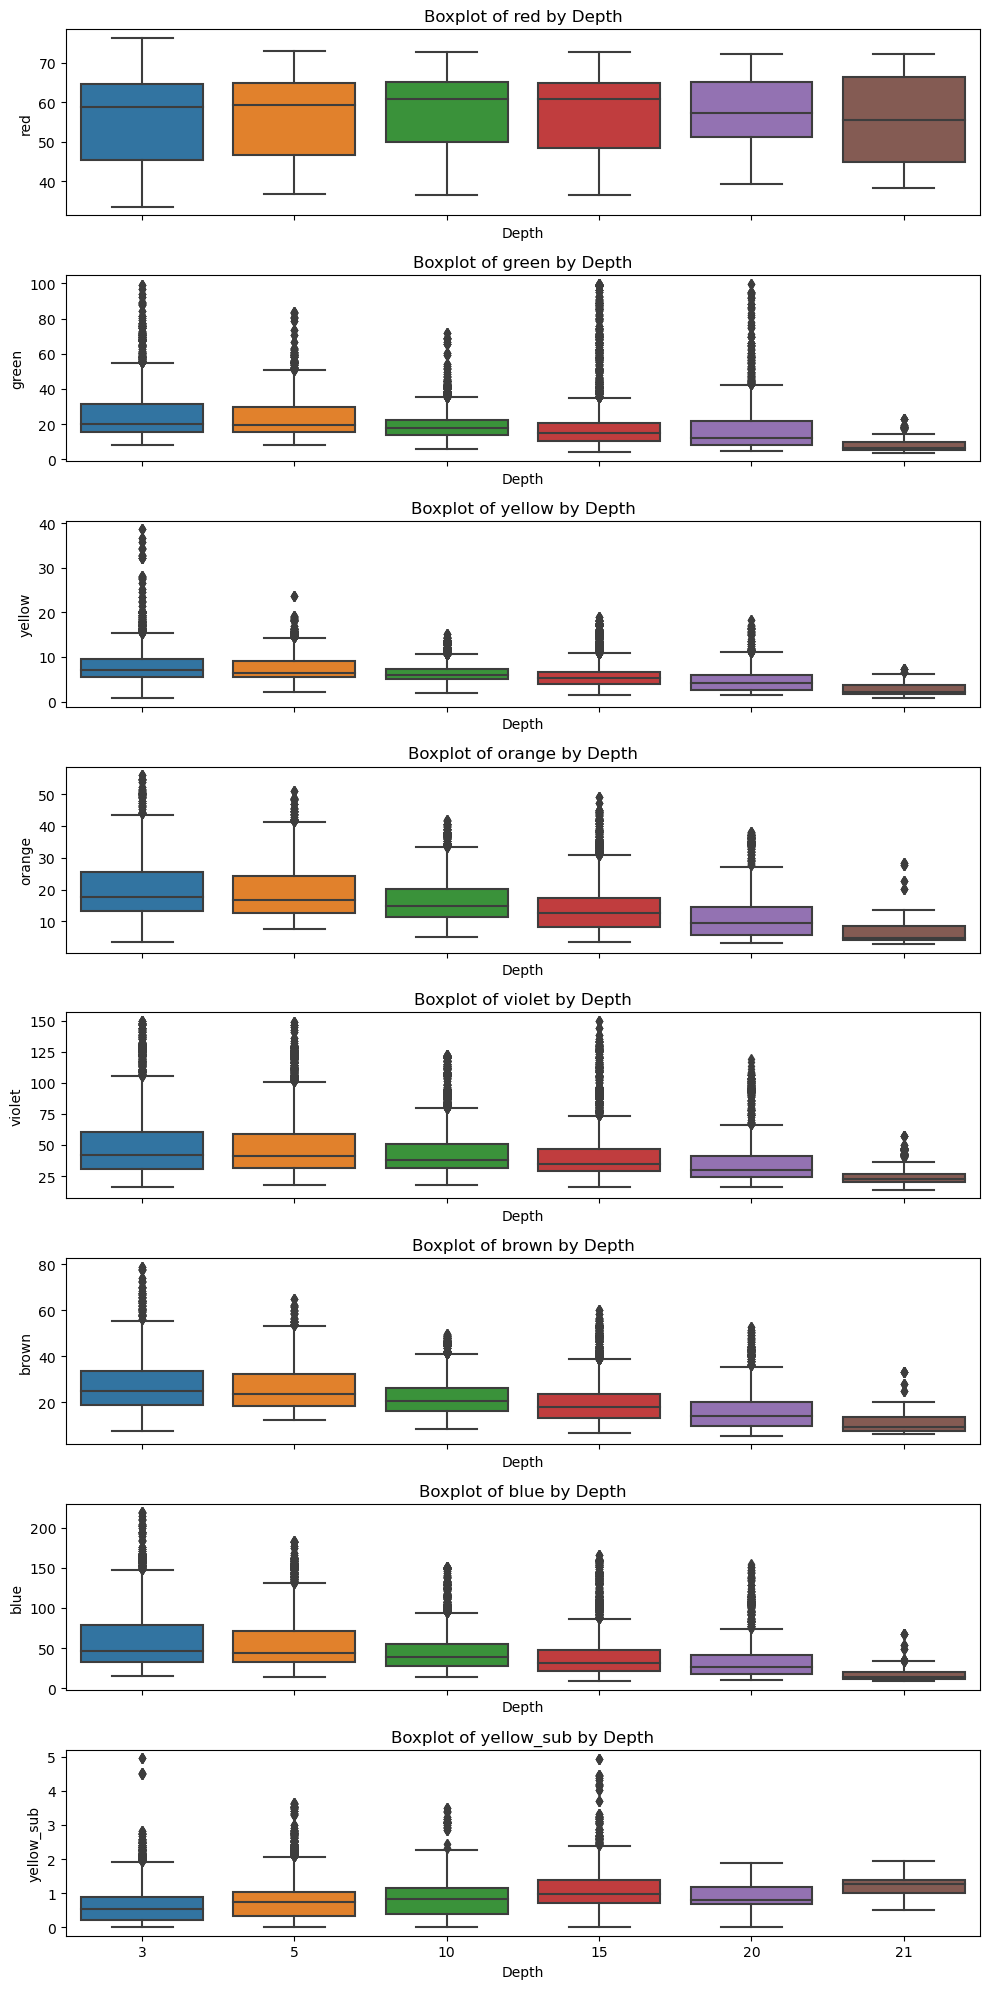

In [20]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

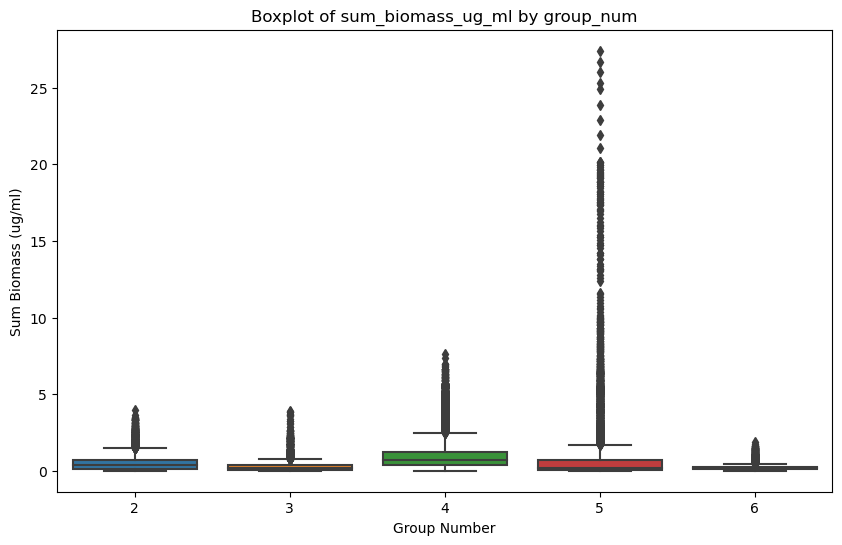

In [21]:
boxplot_biomass_by_group(merged_train)

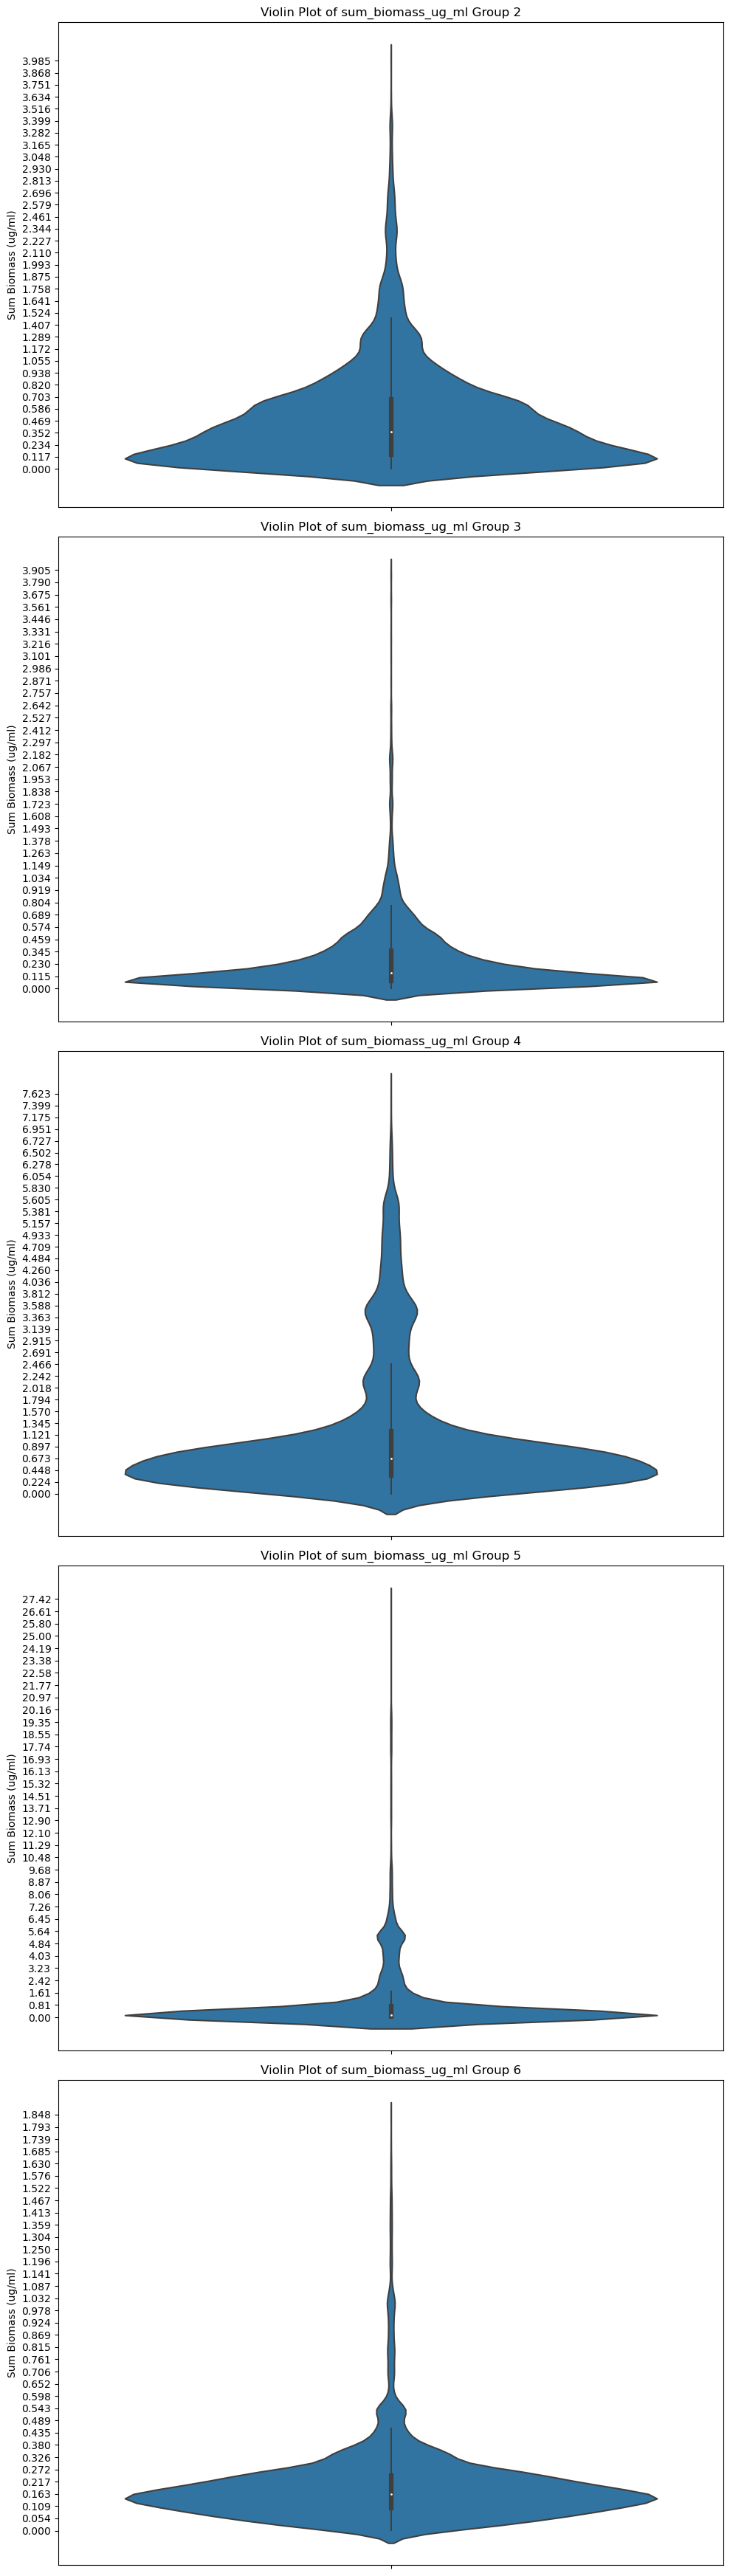

In [22]:
violin_biomass_by_group(merged_train)

In [23]:
# ranges_dict = {
#     2: (0, 0.5, 0.5),
#     3: (0, 0.3, 0.6),
#     4: (0.1, 1, 0.6),
#     5: (0, 0.8, 0.6),
#     6: (0, 0.25, 0.6)
# }

# undersample_merged = undersample_within_ranges(merged_train, ranges_dict)

In [24]:
# undersample_merged.shape

In [25]:
# merged_train.shape

In [26]:
# violin_biomass_by_group(undersample_merged)

In [27]:
# boundaries = {
#     2: (0.1, 2.5),
#     3: (0, 2),
#     4: (0, 5),
#     5: (0, 3),
#     6: (0.02, 1)
# }

# filter_biomass_by_group_boundaries(merged_train, boundaries)

In [28]:
# merged_train.shape

In [29]:
# undersample_merged['sum_biomass_ug_ml'] = undersample_merged['sum_biomass_ug_ml'].apply(np.log)
# boxplot_biomass_by_group(undersample_merged)
# undersample_merged['sum_biomass_ug_ml'] = undersample_merged['sum_biomass_ug_ml'].apply(np.exp)

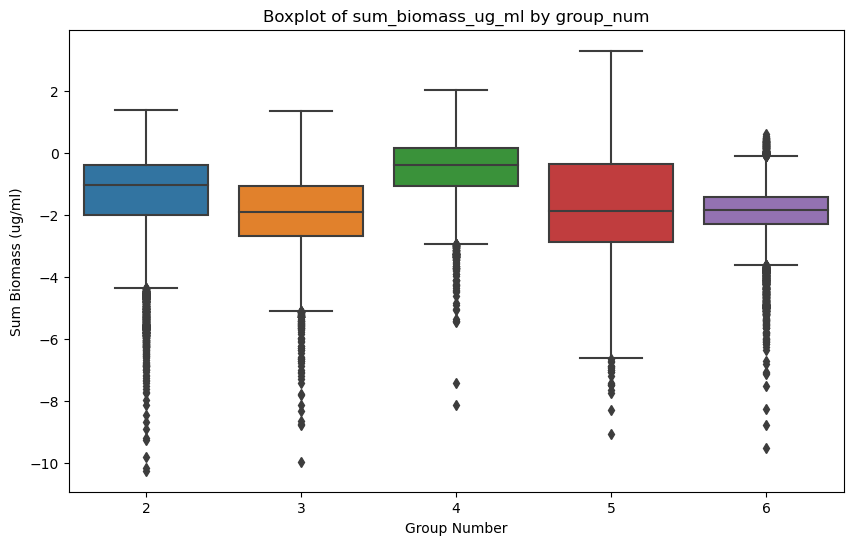

In [30]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.log)
boxplot_biomass_by_group(merged_train)

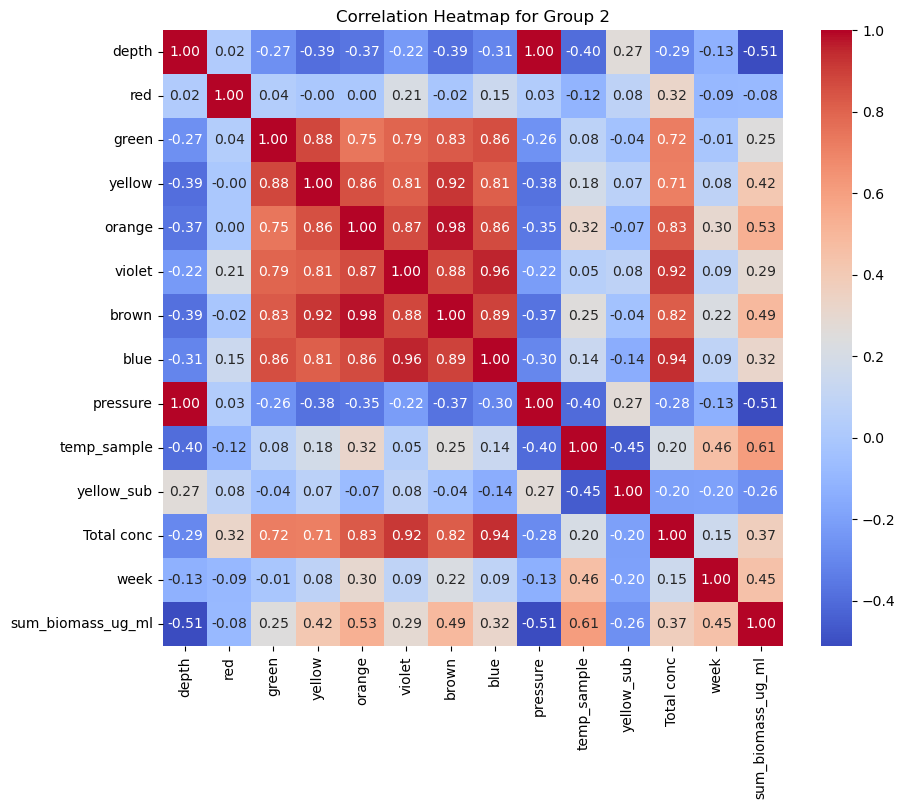

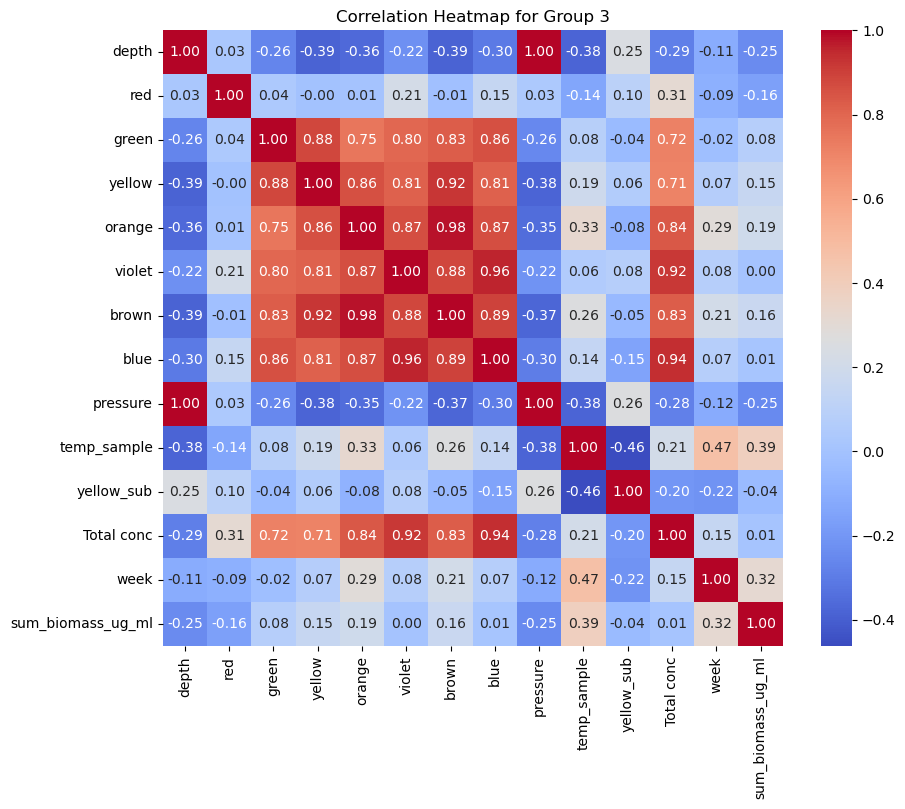

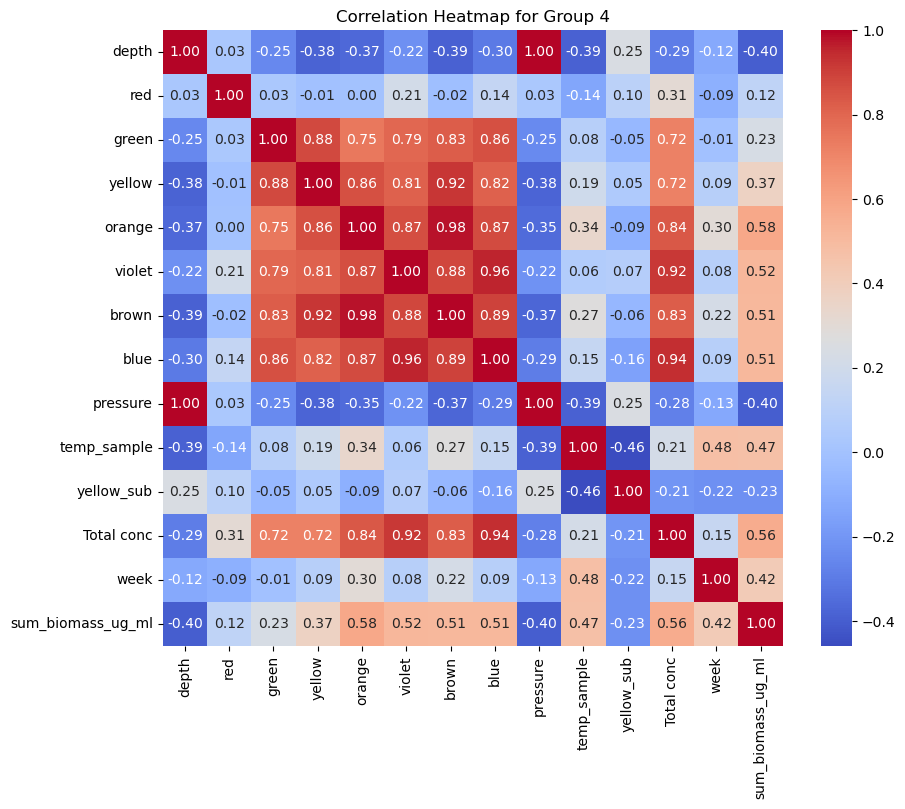

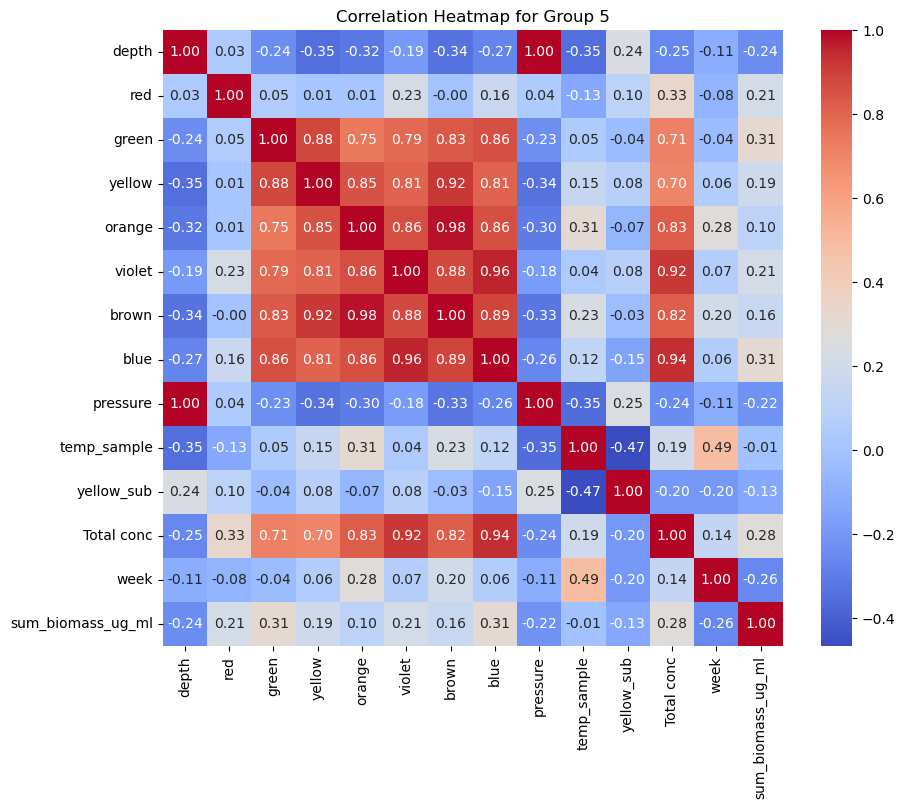

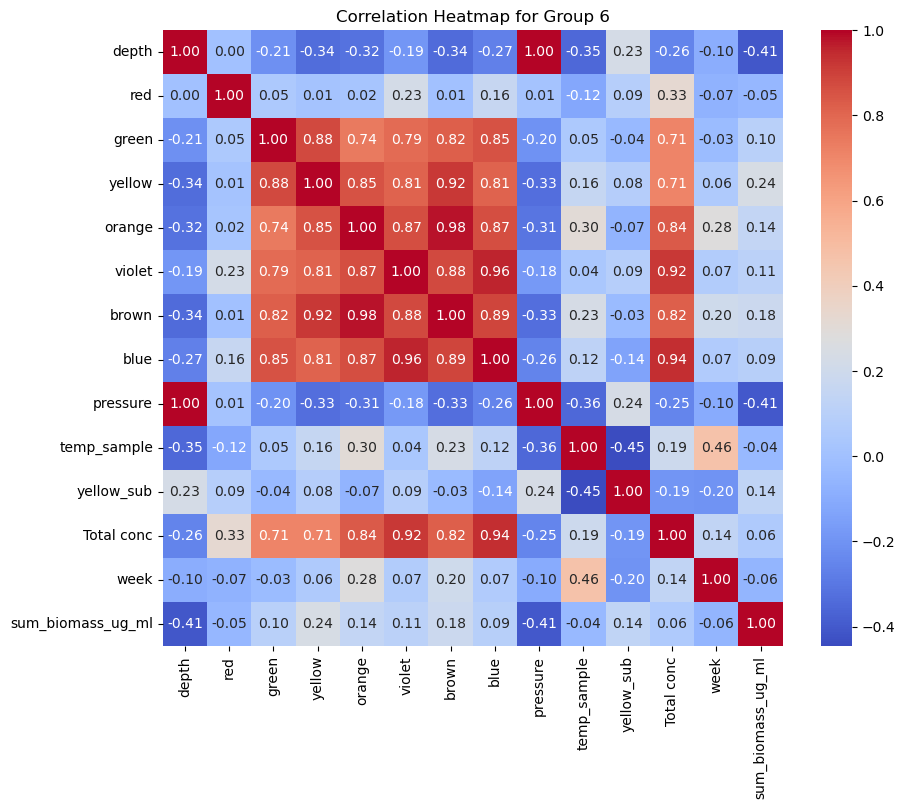

In [31]:
correlation_per_group(merged_train)

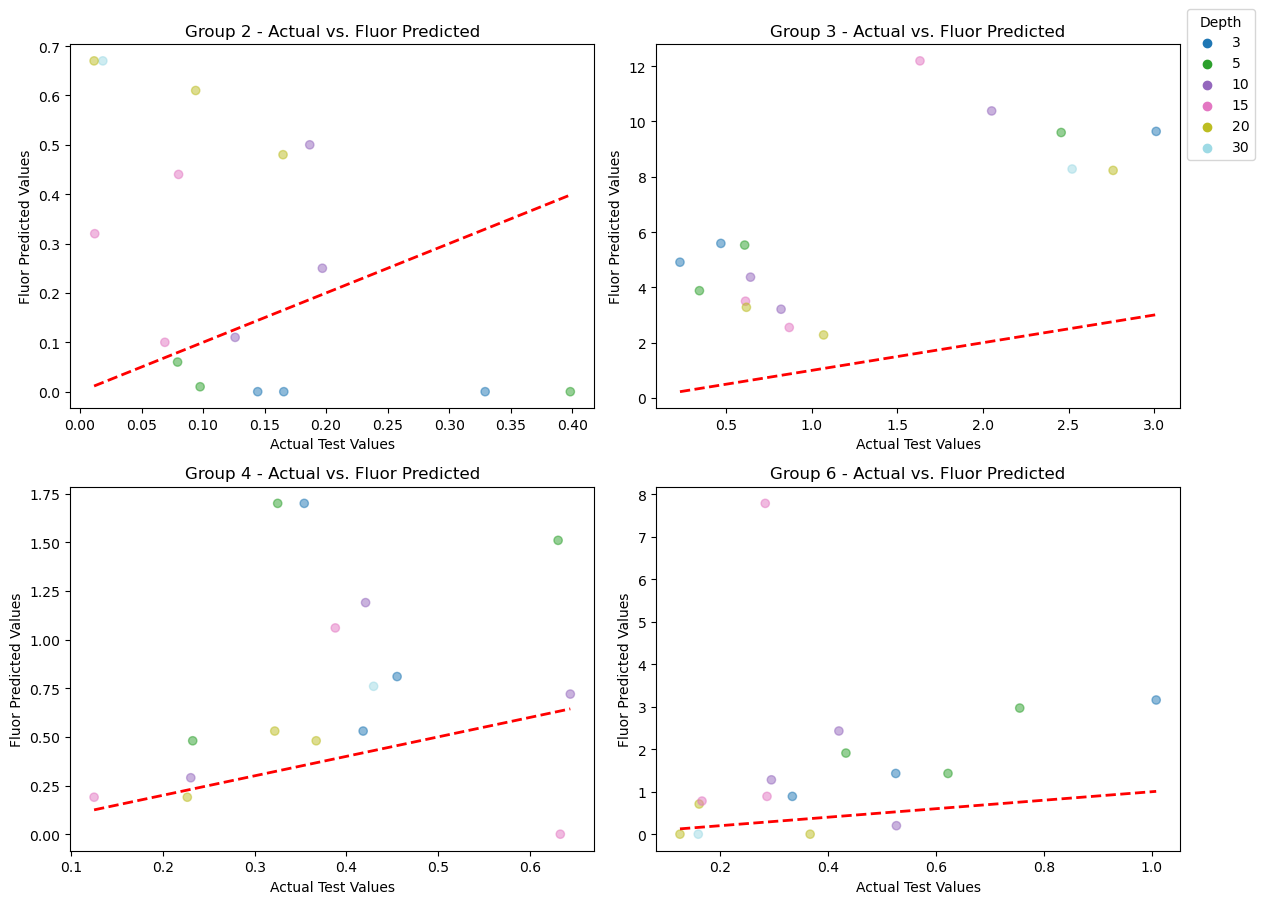

In [32]:
plot_fluorprobe_prediction(fluor_val_df, fluor_groups_map)

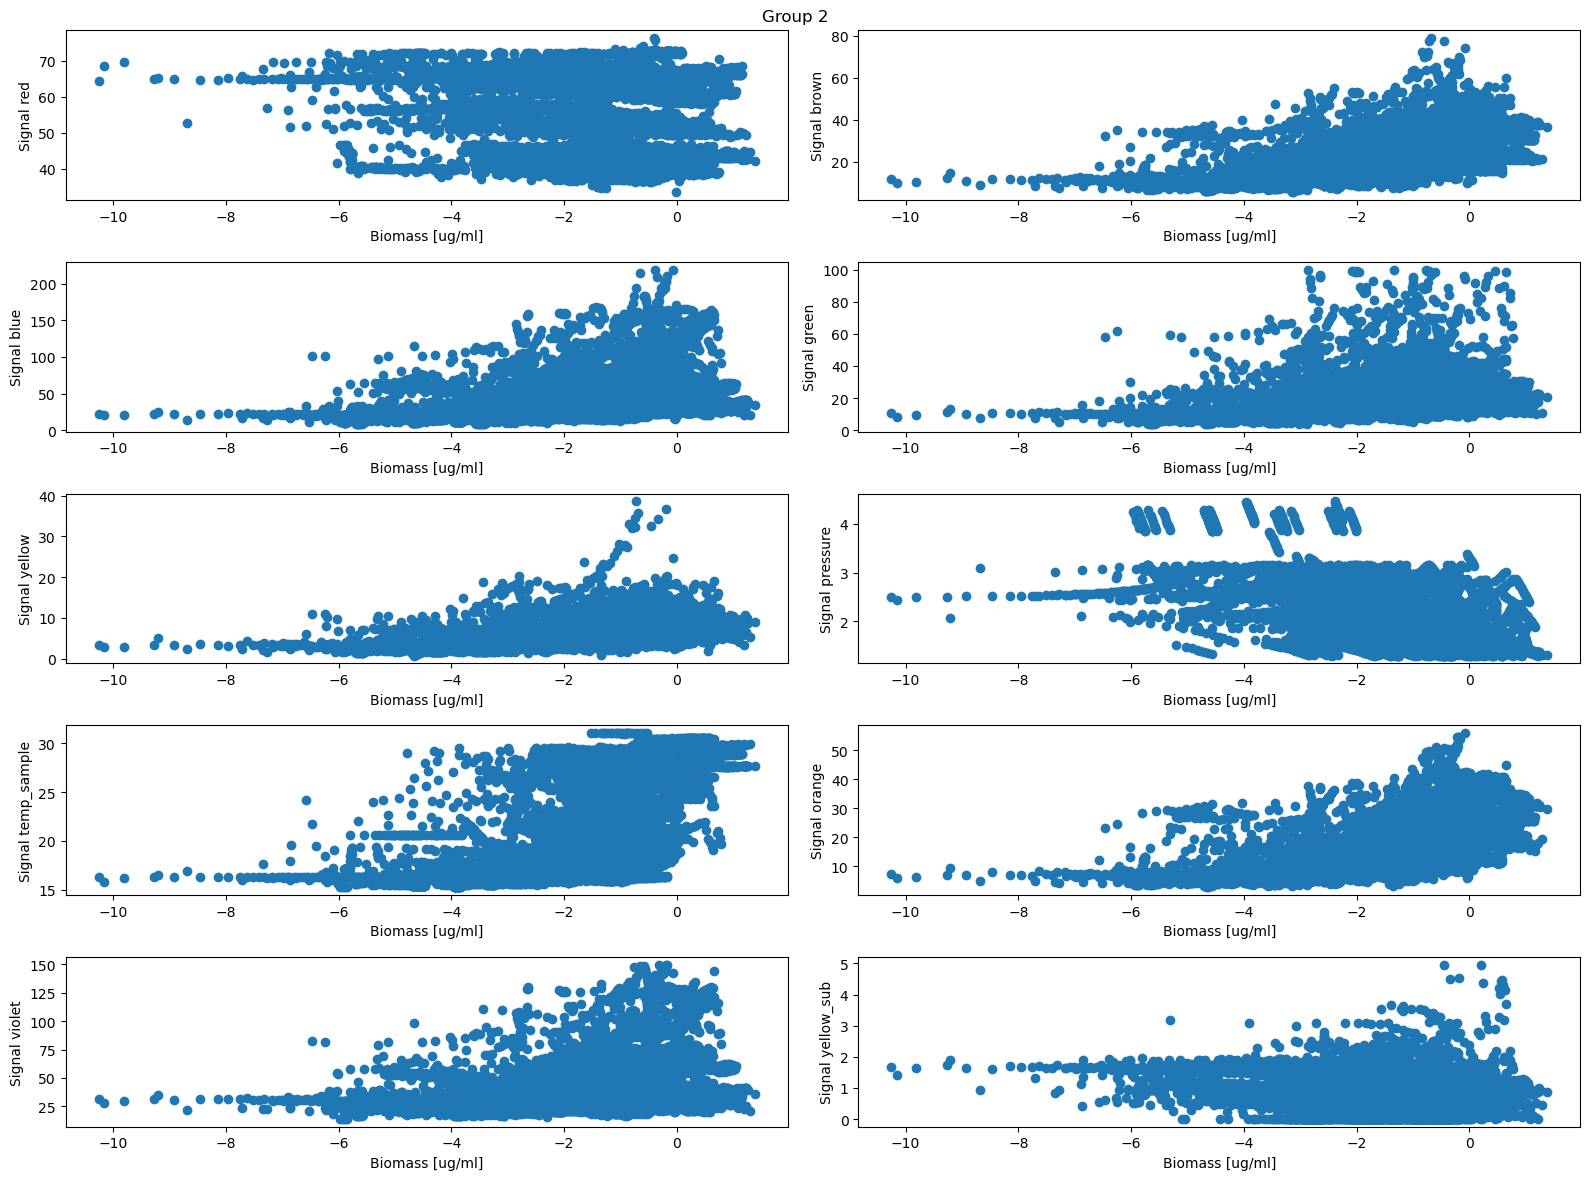

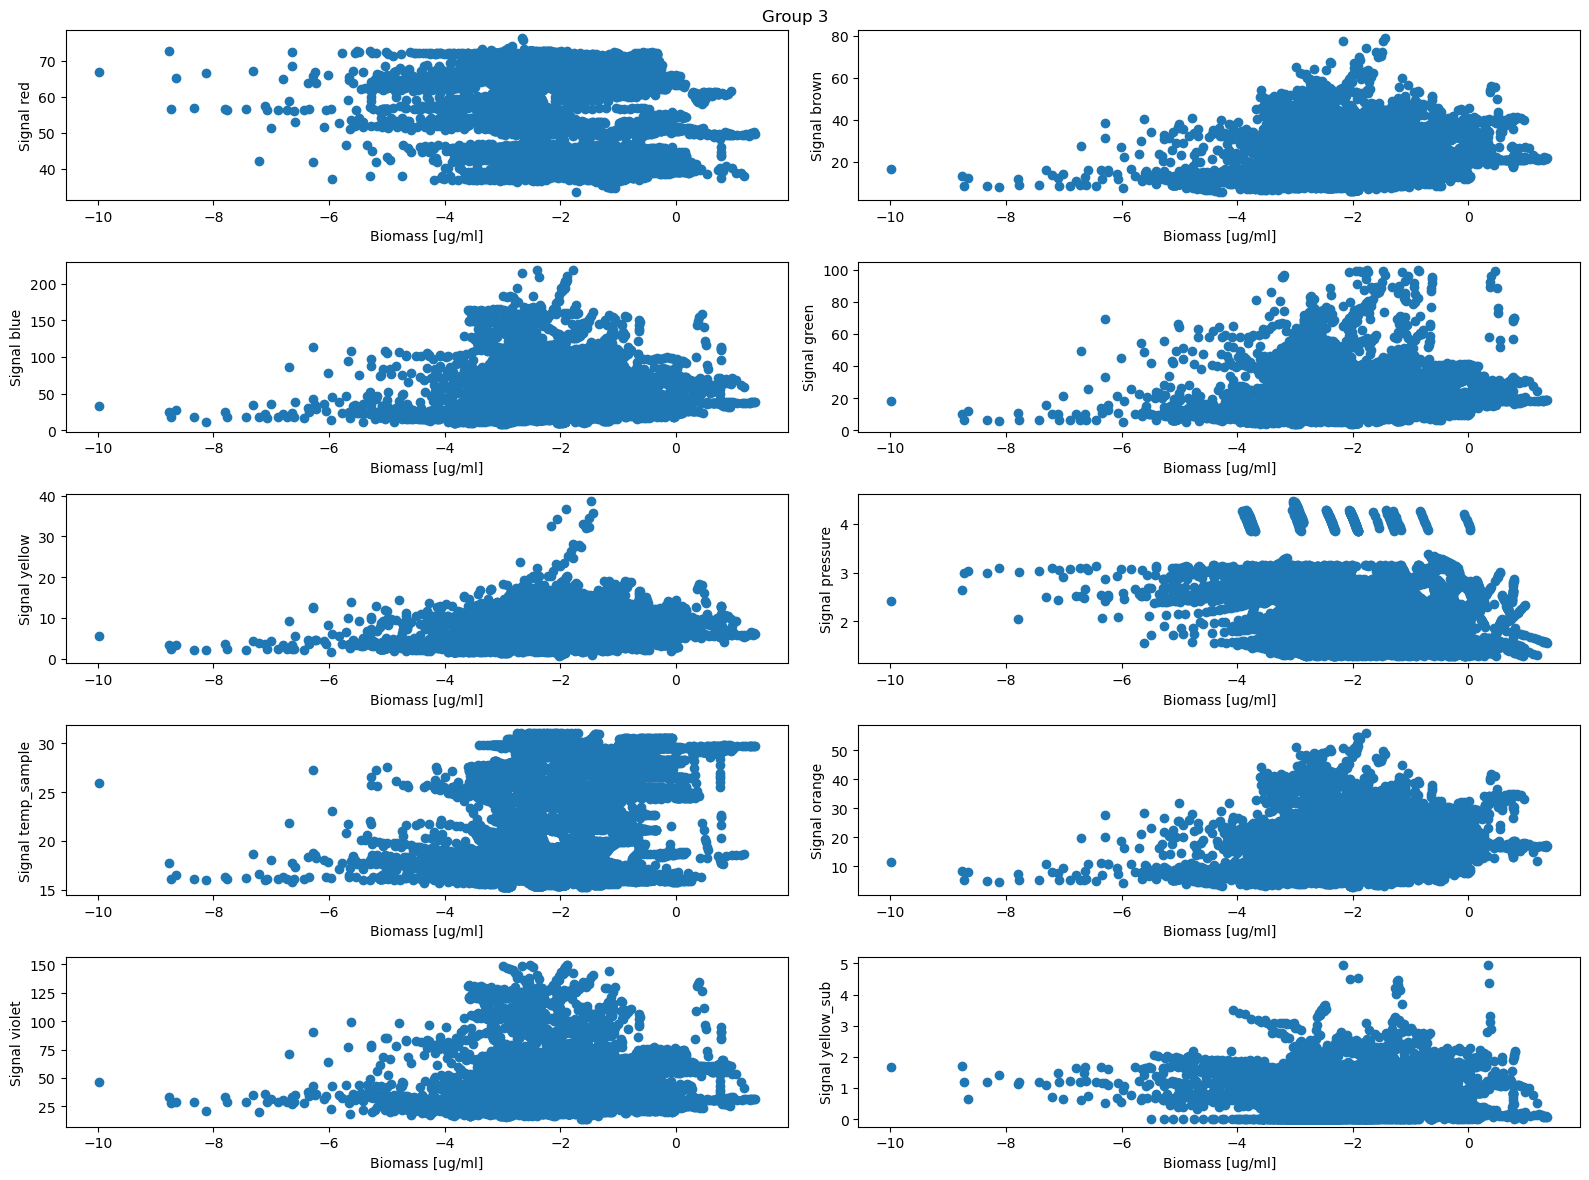

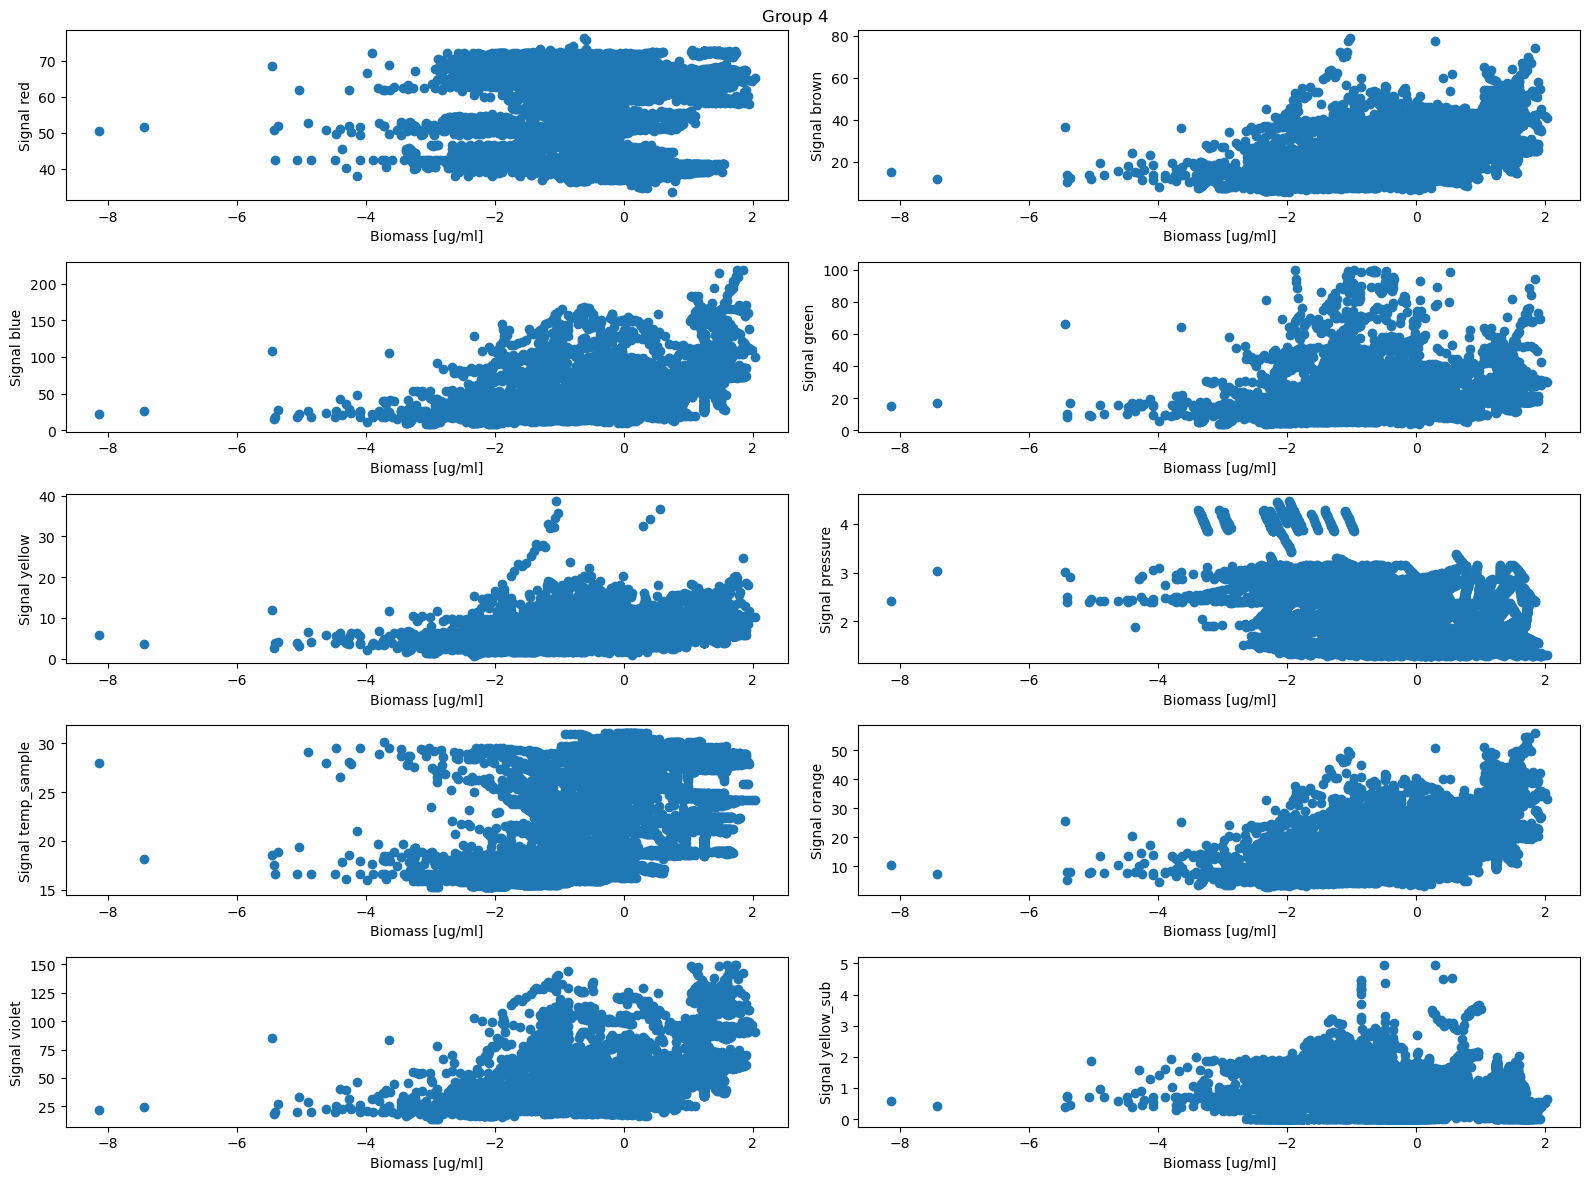

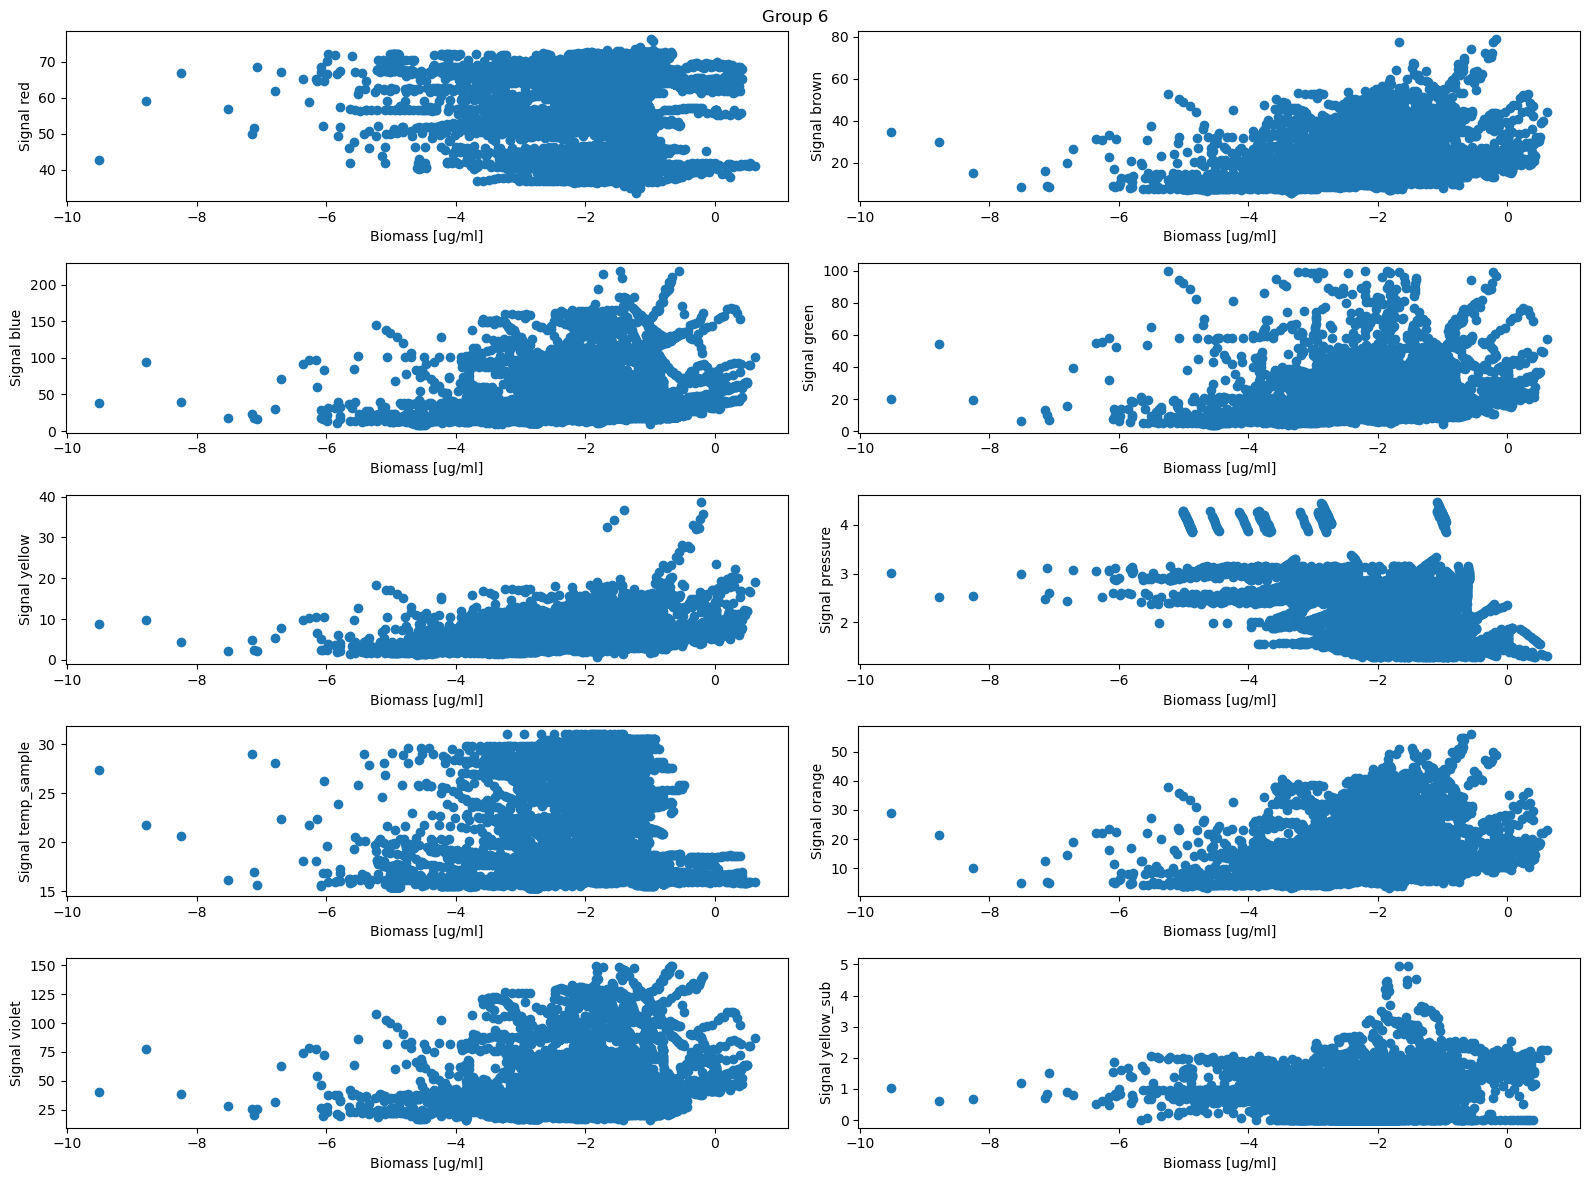

In [33]:
plot_corr_per_feature_per_group(merged_train, fluor_groups_map)

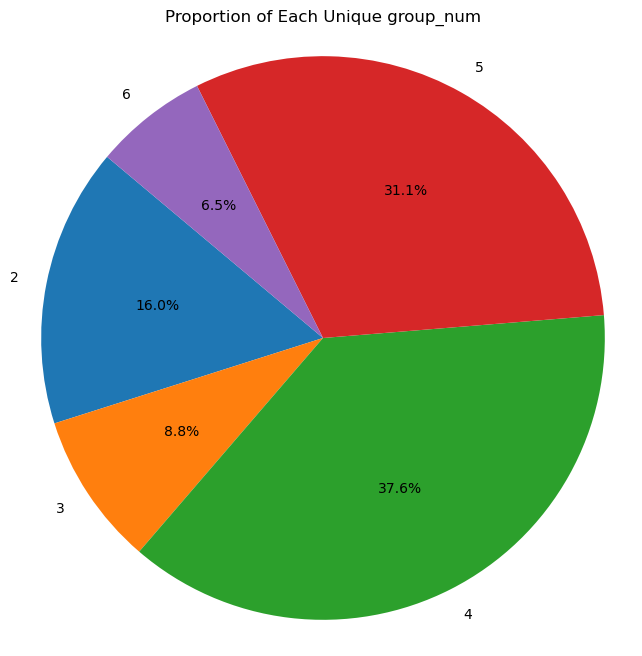

In [34]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.exp)
groups_pie_chart(merged_train, by_biomass=True)

In [35]:
merged_train = merged_train.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)
orig_merged_train = orig_merged_train.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)
# undersample_merged = undersample_merged.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)
# merged_test = merged_test.drop(['year', 'Depth', 'week', 'depth_discrete', 'month'], axis=1)
# merged_val = merged_val.drop(['year', 'Depth', 'week', 'depth_discrete', 'month'], axis=1)

# Training models and evaluating

In [36]:
pickled_params = 'best_grid_params.pkl'
do_search = not os.path.exists(pickled_params)

def two_scorer(mse=False):
    score = mean_squared_error if mse else r2_score
    return make_scorer(score, greater_is_better=mse==False)

In [37]:
if do_search:
#     param_grid_per_model = {'xgb': {
#         "model__n_estimators": [100, 300, 500], # Number of boosting rounds
#         "model__learning_rate": [0.01, 0.1, 0.2], # Step size shrinkage
#         "model__max_depth": [3, 5, 7, 11], # Maximum depth of a tree,
#         'model__min_child_weight': [1, 5, 7],  # Minimum sum of instance weight needed in a child
#         "model__subsample": [0.2, 0.5, 1.0], # Fraction of samples used for fitting trees
#         "model__colsample_bytree": [0.2, 0.8, 1.0] # Fraction of features used for fitting trees
#     },
#     'svr':  {
#         "model__C": [0.1, 1, 10, 100], # Regularization parameter
#         "model__kernel": ["poly", "rbf"],
#         "model__degree": [1, 2, 3], # Degree of the polynomial kernel (for "poly" kernel)
#         "model__epsilon": [0.01, 0.1, 0.2], # Epsilon in the epsilon-SVR loss function
#         "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
#     },
#     'elf': {
#         "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
#         "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
#         "model__fit_intercept": [True, False], # Whether to calculate the intercept for the model
#     }}
    param_grid_per_model = {'xgb': {
        "model__n_estimators": [100, 300, 500], # Number of boosting rounds
        "model__max_depth": [2, 3, 5], # Maximum depth of a tree,
        "model__alpha": [0.01, 0.1, 1, 10], # L1 regularization term
        "model__lambda": [0, 0.2, 0.8], # Mixing parameter between L1 and L2 regularization
    },
    'svr':  {
        "model__C": [0.001, 0.1, 1, 10, 100], # Regularization parameter
        "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
    },
    'elf': {
        "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
        "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
    }}
    
    best_group_params_per_model = {}
    for model_name, param_grid in param_grid_per_model.items():
        best_group_params_per_model[model_name] = grid_search_cv(model_name, merged_train, param_grid=param_grid,
                                                                scoring_method=two_scorer(mse=True))
    
    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model, f)
    
    best_group_params_per_model_fixed = {}
    for model_name, kwargs_per_group in best_group_params_per_model.items():
        best_group_params_per_model_fixed[model_name] = {}
        for group_num in kwargs_per_group.keys():
            best_group_params_per_model_fixed[model_name][group_num] = {}
            kwargs = kwargs_per_group[group_num]
            for param, val in kwargs.items():
                fixed_param = param.split('model__')[1]
                best_group_params_per_model_fixed[model_name][group_num][fixed_param] = val


    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model_fixed, f)

else:
    with open(pickled_params, 'rb') as f:
        best_group_params_per_model_fixed = pickle.load(f)

In [38]:
regression_models = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models[model_name], _ = train(model_name, merged_train, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models['lr'], _ = train('lr', merged_train, test_size=0.0, biomass_fn=np.log)

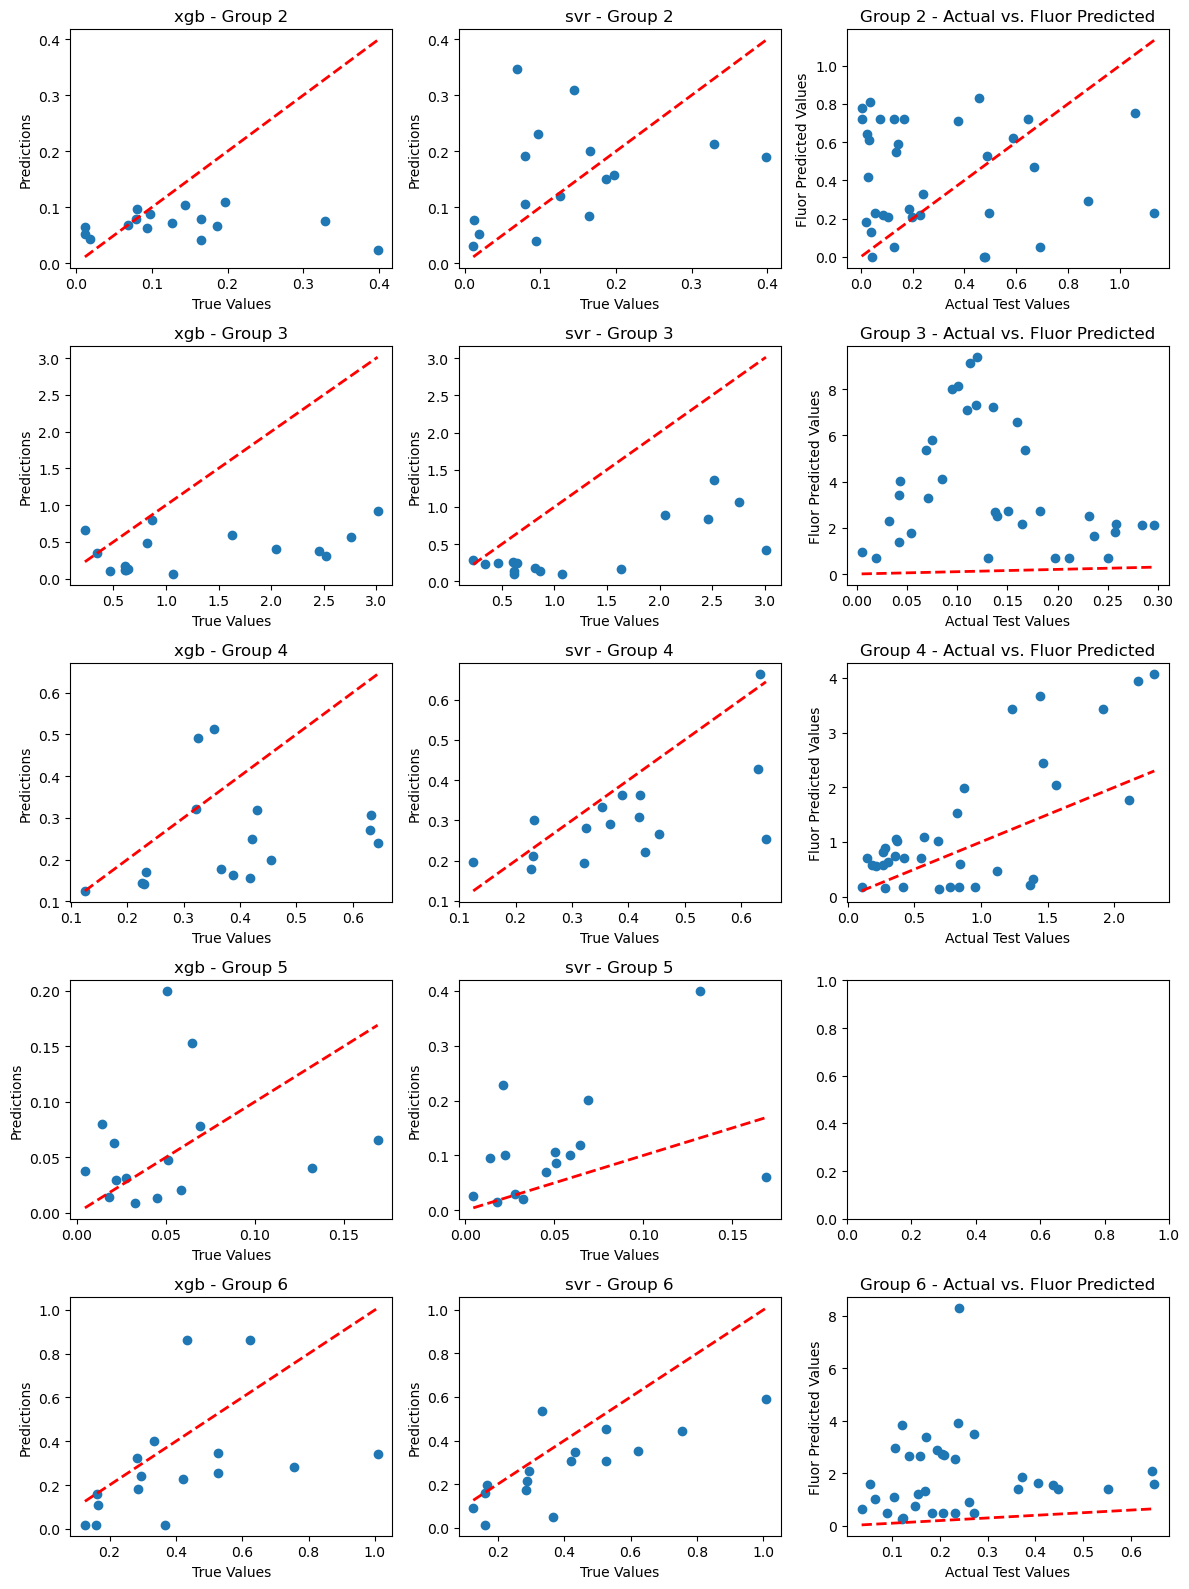

In [39]:
comparing_df = compare_all_models(regression_models, merged_val.drop(['year', 'Depth', 'week', 'month'], axis=1), fluor_test_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr'])

In [40]:
comparing_df.groupby('Model').mean()[['RMSE', 'MAPE']]

RMSE       MAPE
Model                     
FP     2.010829  16.578301
svr    0.334022   0.948679
xgb    0.384518   0.821281

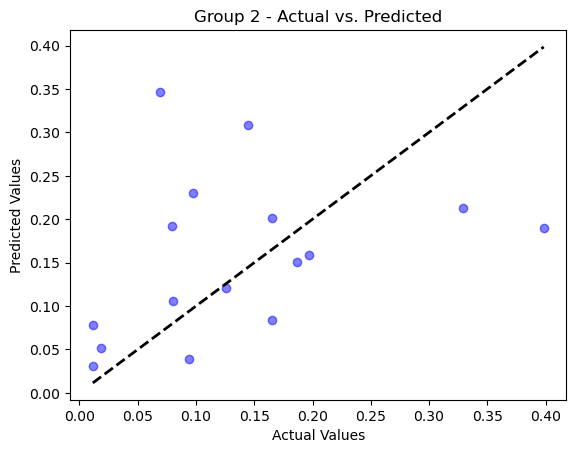

Results for group_num 2:
MSE: 0.013250169564184552
R-squared: -0.2244946314820988



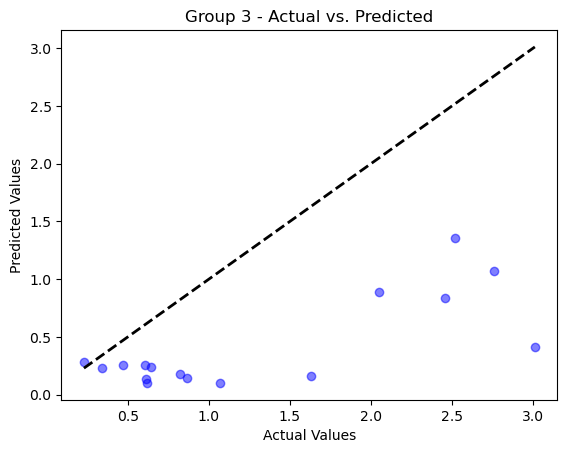

Results for group_num 3:
MSE: 1.2378252013620517
R-squared: -0.4505138459881224



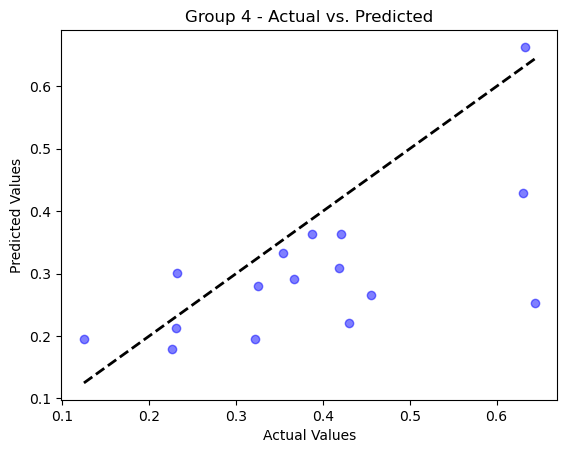

Results for group_num 4:
MSE: 0.020415144420414384
R-squared: 0.058897933010416126



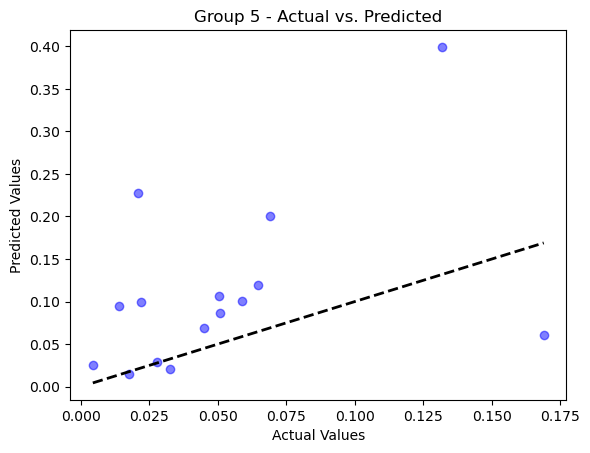

Results for group_num 5:
MSE: 0.011097771367235424
R-squared: -4.87233551579985



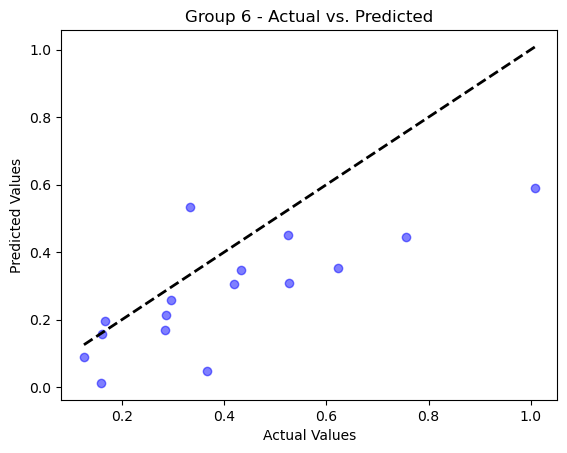

Results for group_num 6:
MSE: 0.037711844927747054
R-squared: 0.30358675510973276

Total MSE: 0.2640600263283266, Total R-squared: -1.0369718610299843


In [41]:
eval_test(regression_models['svr'], merged_val.drop(['week', 'month', 'year', 'Depth'], axis=1), prediction_fn=np.exp)

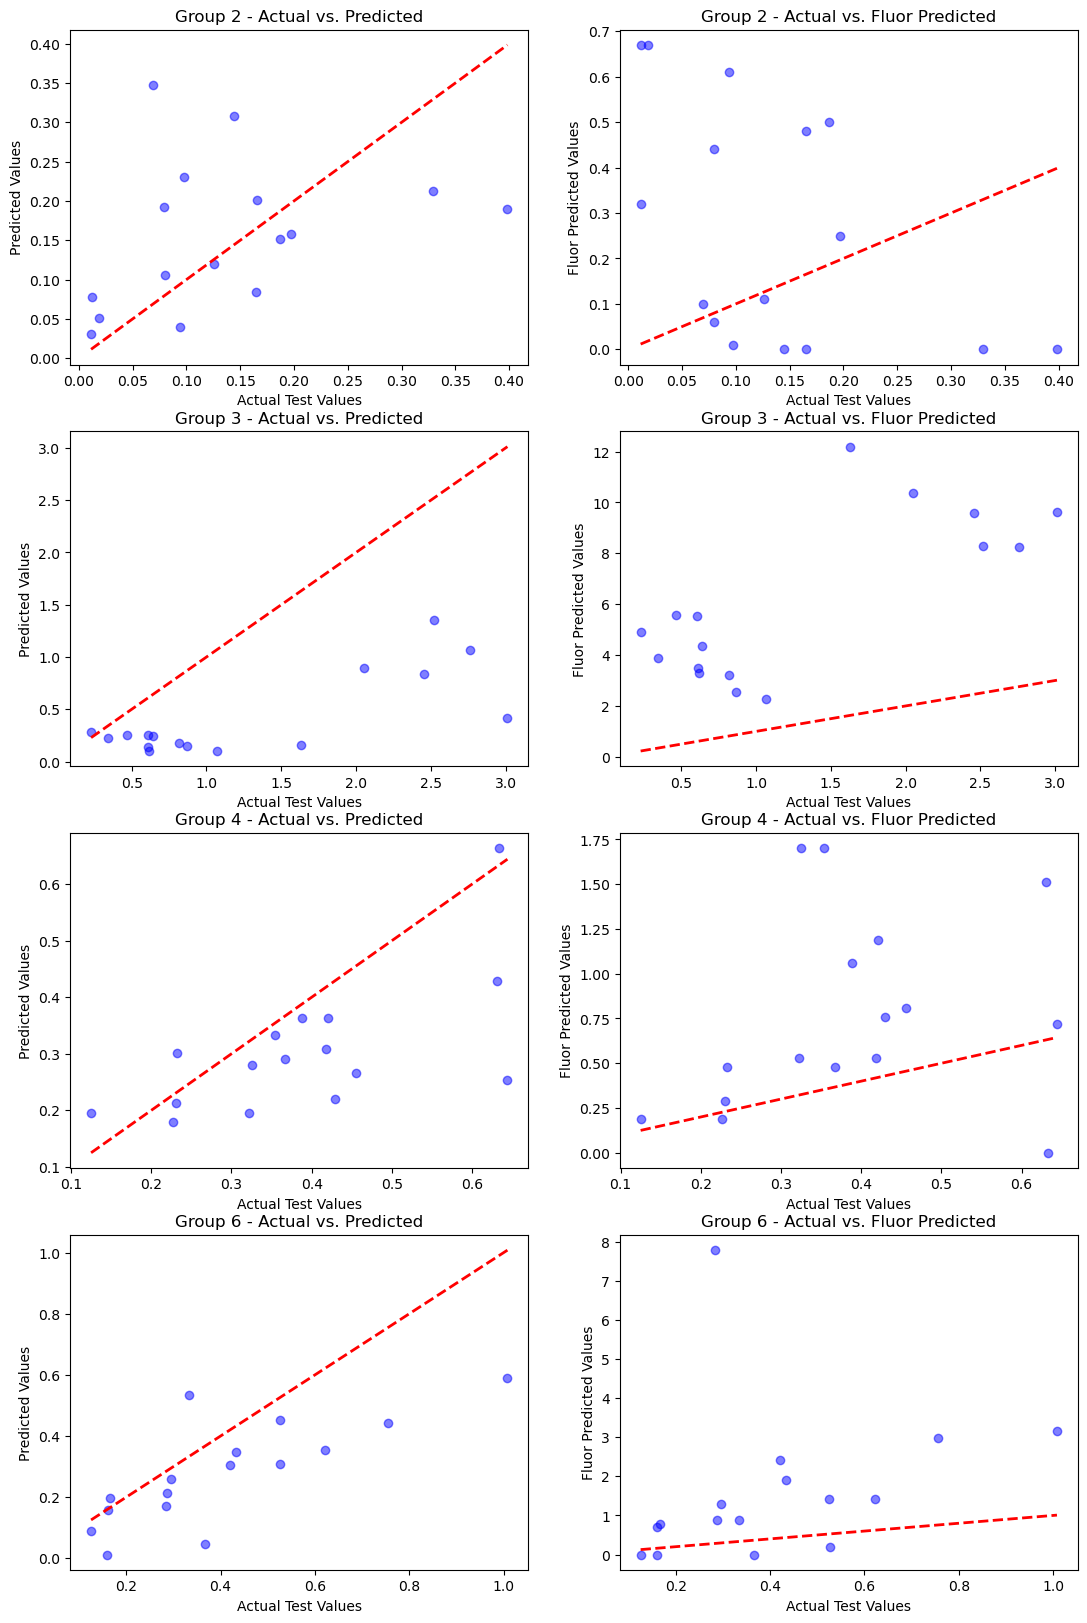

In [42]:
compare_to_fluor(regression_models['svr'], merged_val.drop(['week', 'month', 'year', 'Depth'], axis=1), fluor_groups_map, fluor_val_df, predict_fn=np.exp)

In [43]:
cleaned_res = compare_by_mpe(merged_val, regression_models, predict_fn=np.exp)

In [44]:
fp_res = calc_mpe_fp(fluor_val_df, with_group_5=False)

# With SMOGN

In [45]:
import smogn
import seaborn

In [46]:
smogn_file = './data/smogn_merged_train.pkl'
do_smogn = not os.path.exists(smogn_file)

In [47]:
if do_smogn:
    merged_train_smogn = []
    for group_num in merged_train['group_num'].unique():
        group_df = merged_train[merged_train['group_num'] == group_num]
        print(f'********Group {group_num}************')
        print(group_df.shape)
        group_df_smogn = smogn.smoter(
            data = group_df.reset_index(drop=True),  ## pandas dataframe
            y = 'sum_biomass_ug_ml'  ## string ('header name')
        )
        print(group_df_smogn.shape)

        ## plot y distribution 
        plt.figure(figsize=(8, 6))
        seaborn.kdeplot(group_df['sum_biomass_ug_ml'], label = "Original")
        seaborn.kdeplot(group_df_smogn['sum_biomass_ug_ml'], label = "Modified")
        plt.legend()
        plt.show()

        merged_train_smogn.append(group_df_smogn)


    merged_train_smogn_concat = pd.concat(merged_train_smogn, ignore_index=True)
    with open(smogn_file, 'wb') as f:
        pickle.dump(merged_train_smogn_concat, f)
        
else:
    with open(smogn_file, 'rb') as f:
        merged_train_smogn_concat = pickle.load(f)

In [48]:
regression_models_smogn = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models_smogn[model_name], _ = train(model_name, merged_train_smogn_concat, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models_smogn['lr'], _ = train('lr', merged_train_smogn_concat, test_size=0.0, biomass_fn=np.log)

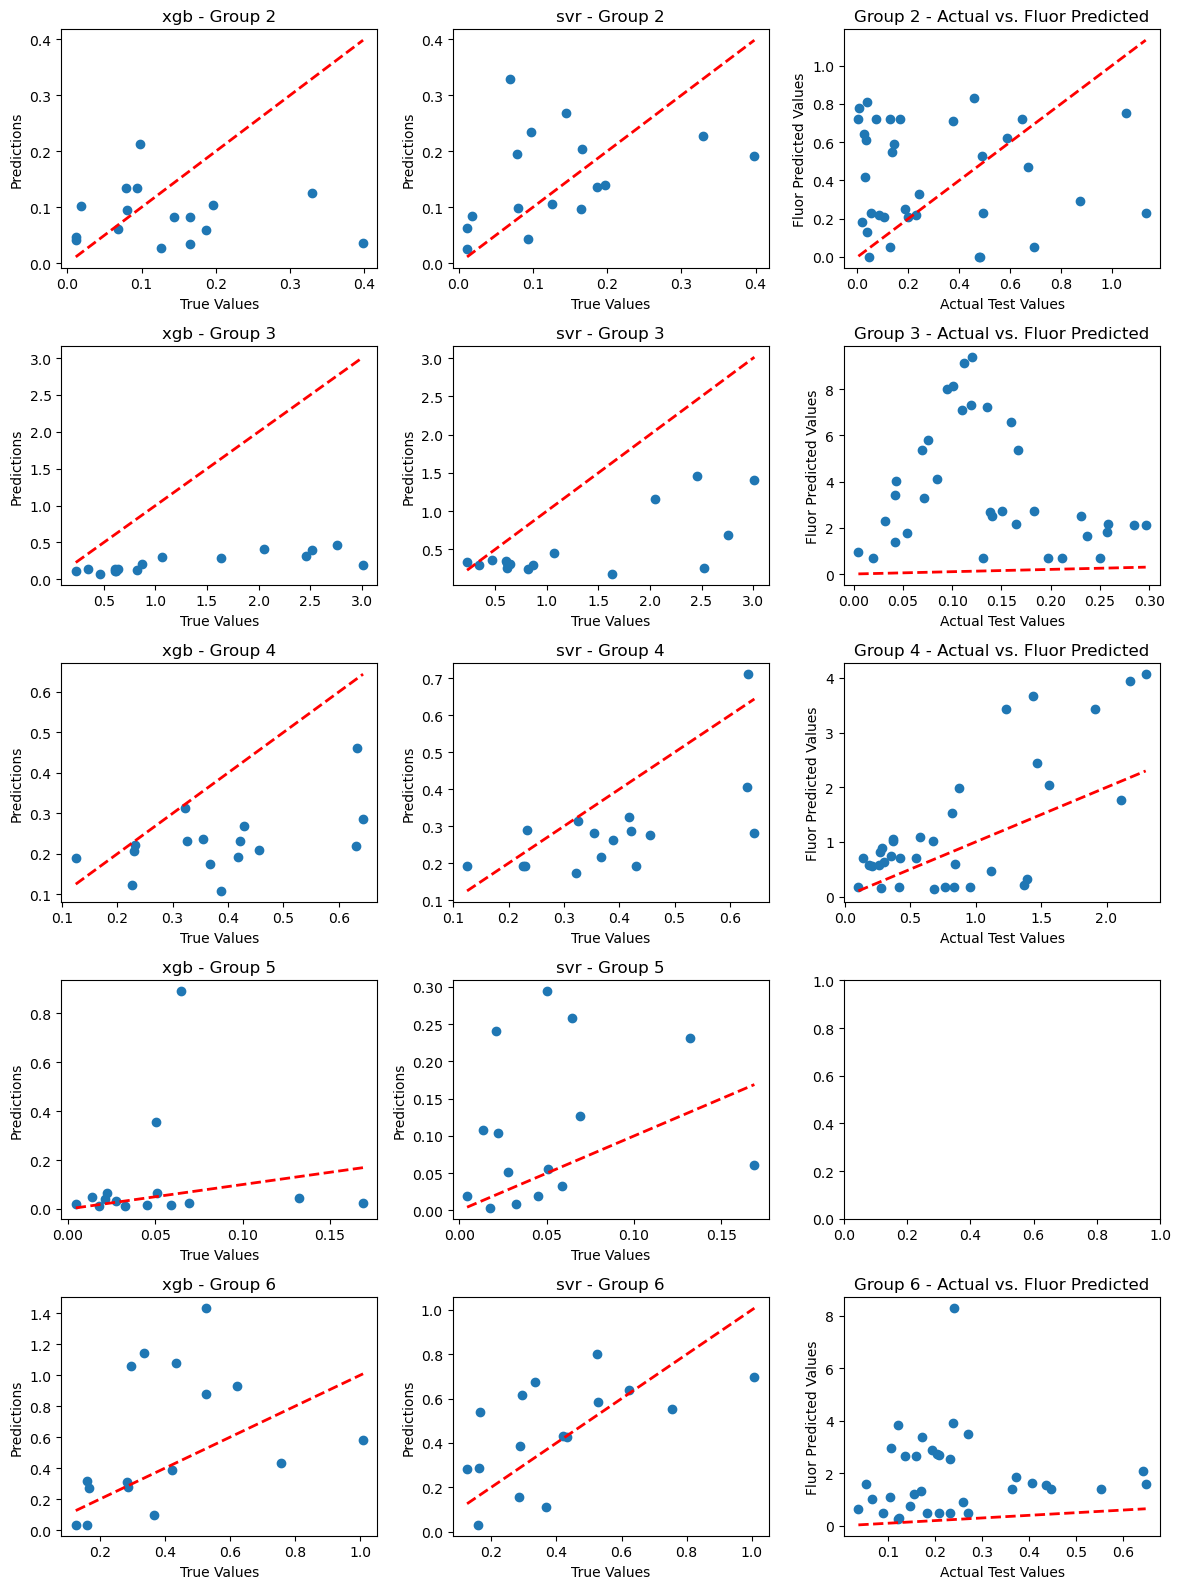

In [49]:
comparing_df_smogn = compare_all_models(regression_models_smogn, merged_val.drop(['year', 'Depth', 'week', 'month'], axis=1), fluor_test_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr'])

In [50]:
cleaned_smogn_res = compare_by_mpe(merged_val, regression_models_smogn, predict_fn=np.exp)

# No Outliers Removal

In [51]:
regression_models_orig = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models_orig[model_name], _ = train(model_name, orig_merged_train, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models_orig['lr'], _ = train('lr', orig_merged_train, test_size=0.0, biomass_fn=np.log)

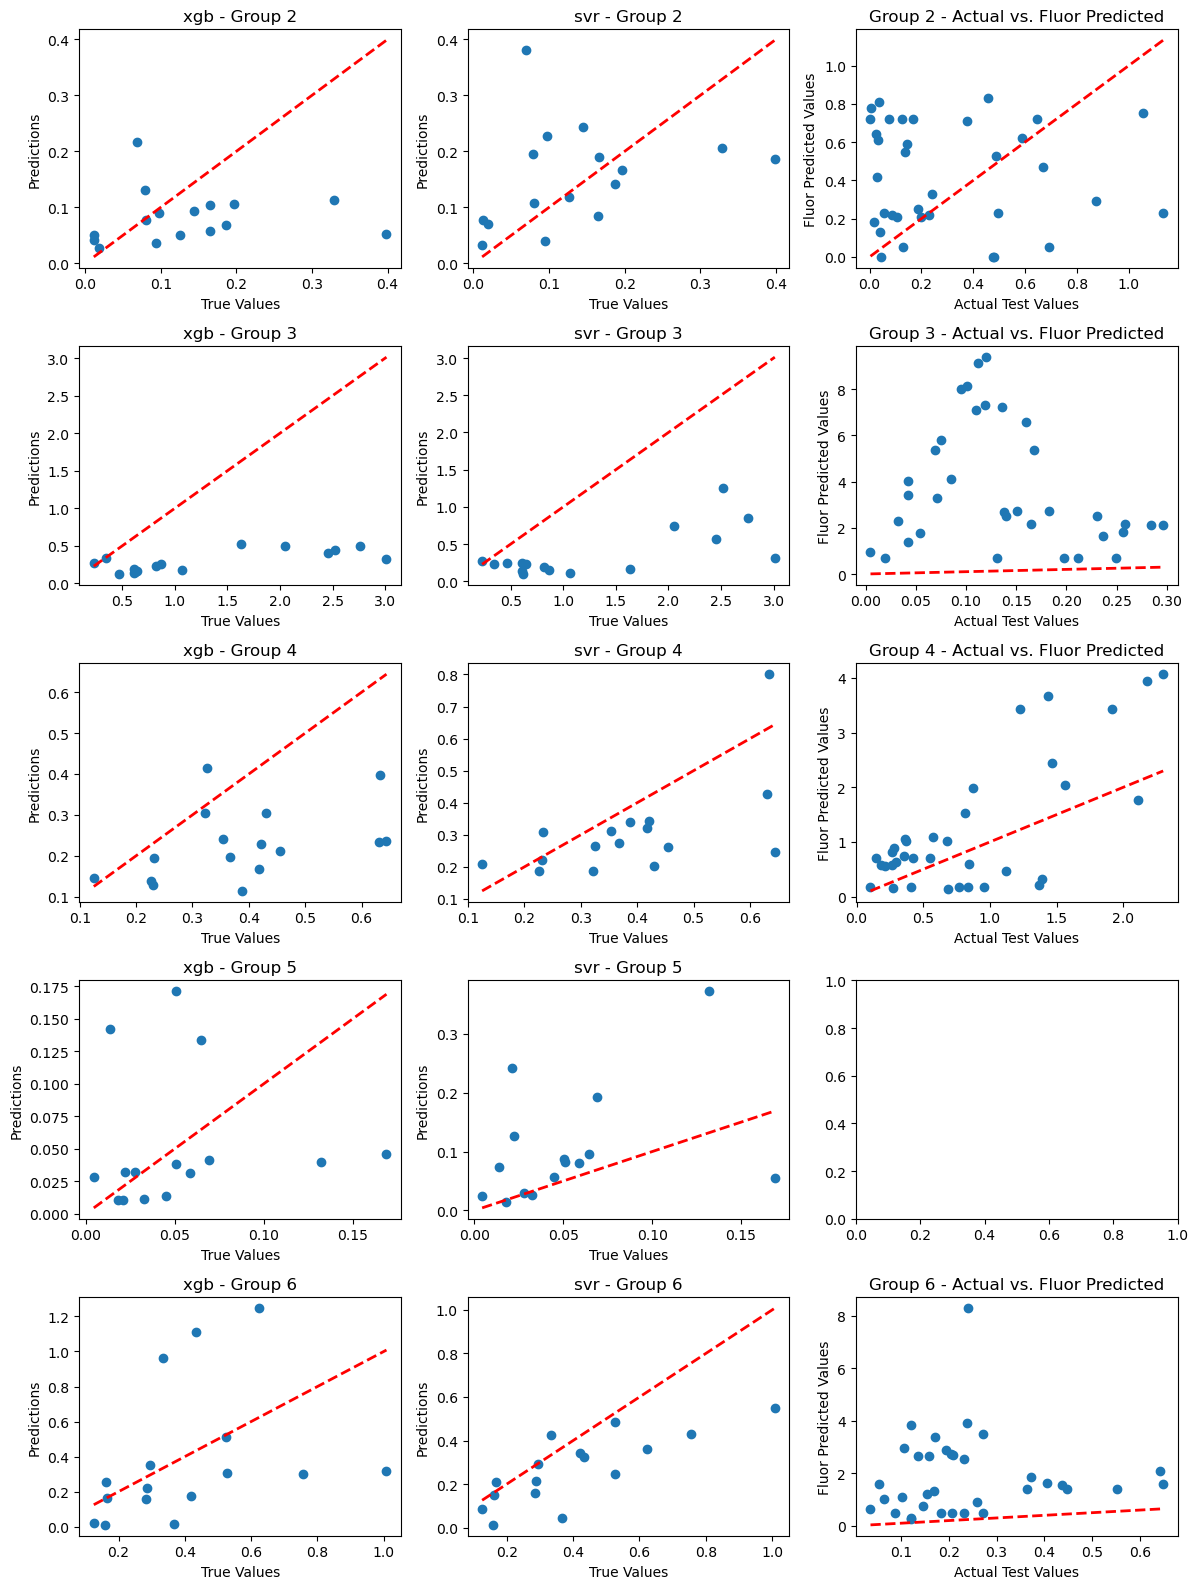

In [52]:
comparing_df_orig = compare_all_models(regression_models_orig, merged_val.drop(['year', 'Depth', 'week', 'month'], axis=1), fluor_test_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr'])

In [53]:
not_cleaned_res = compare_by_mpe(merged_val, regression_models_orig, predict_fn=np.exp)

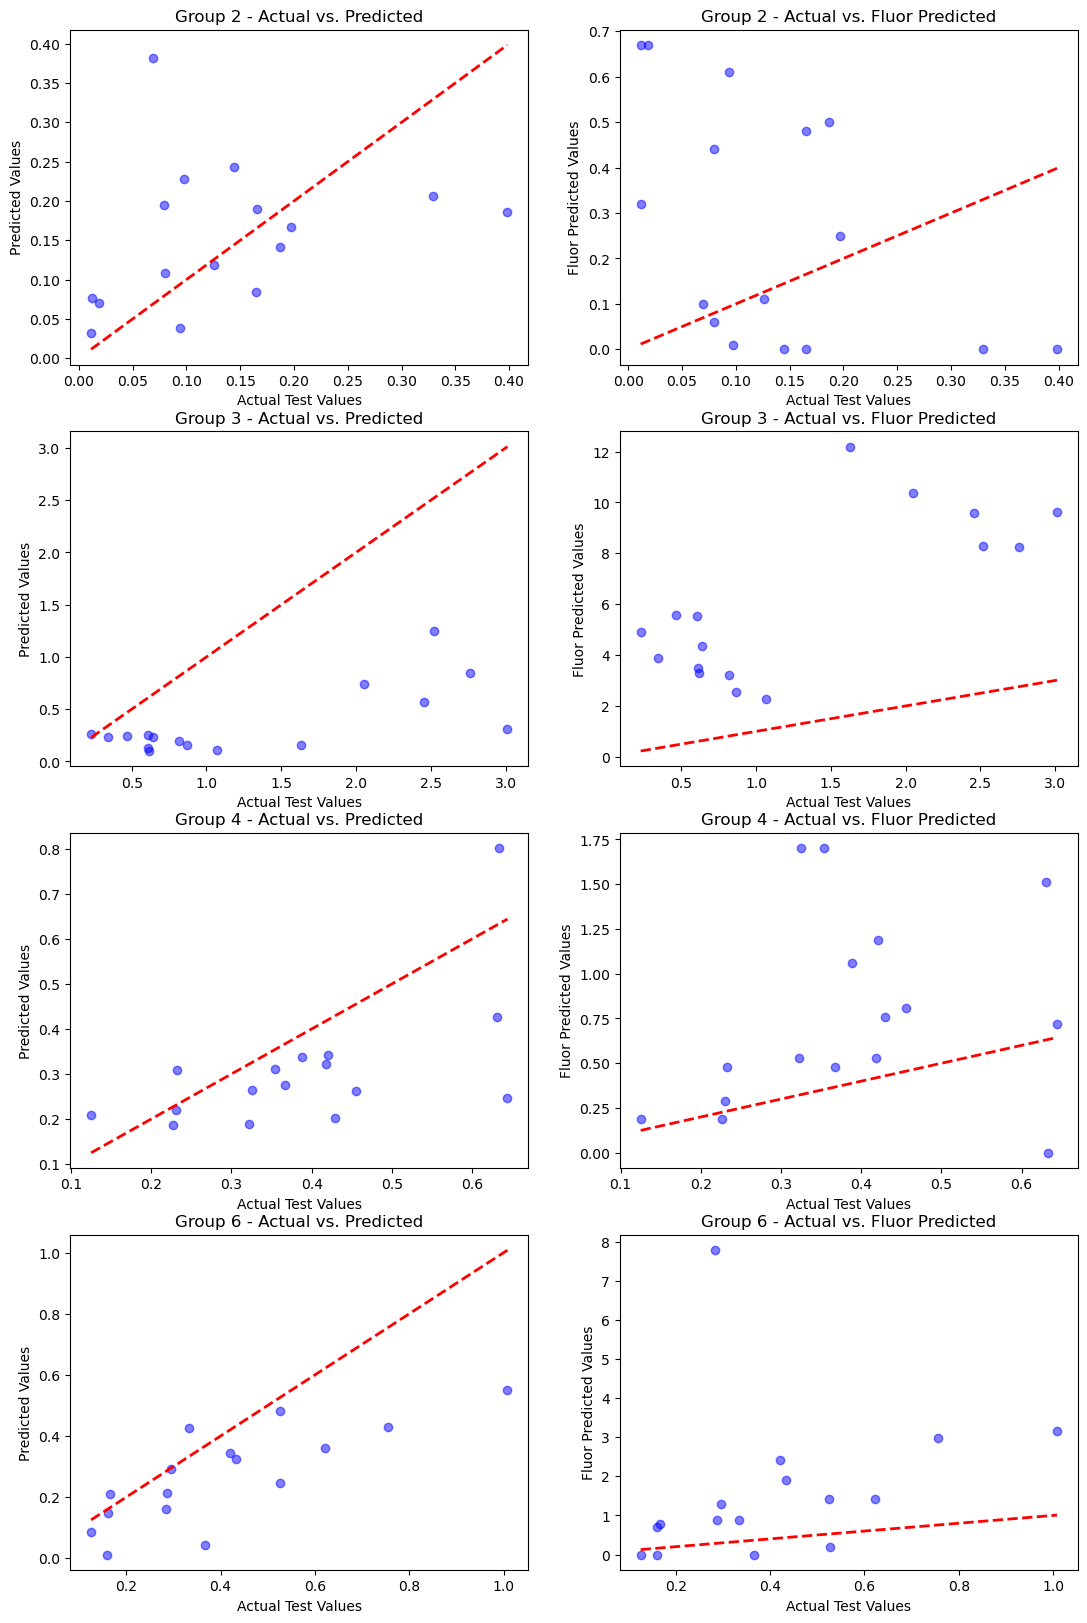

In [54]:
compare_to_fluor(regression_models_orig['svr'], merged_val.drop(['week', 'month', 'year', 'Depth'], axis=1), fluor_groups_map, fluor_val_df, predict_fn=np.exp)

# With Outliers With Smogn

In [55]:
smogn_file = './data/with_outliers_smogn_merged_train.pkl'
do_smogn = not os.path.exists(smogn_file)

********Group 2************
(11355, 13)


r_index: 100%|#############################| 1103/1103 [00:01<00:00, 824.15it/s]


(9830, 13)


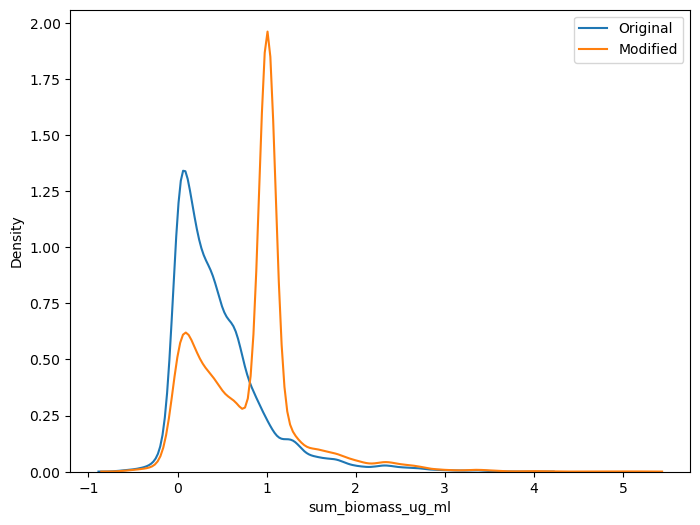

********Group 3************
(11291, 13)


r_index: 100%|#############################| 1766/1766 [00:02<00:00, 811.96it/s]


(13035, 13)


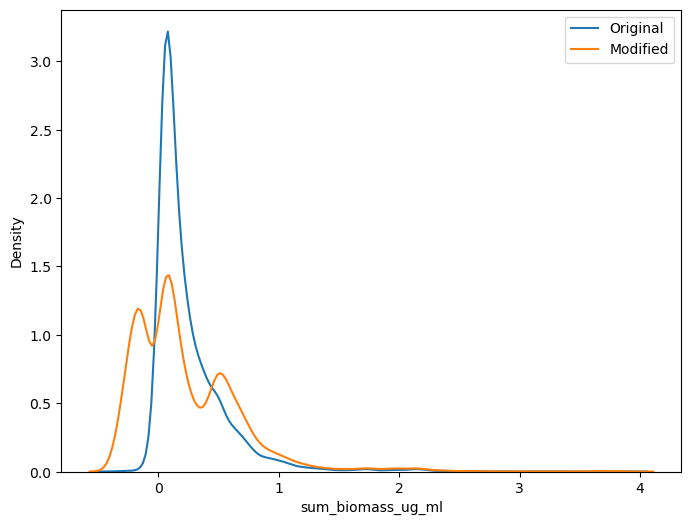

********Group 4************
(11304, 13)


r_index: 100%|#############################| 1523/1523 [00:01<00:00, 778.36it/s]


(12755, 13)


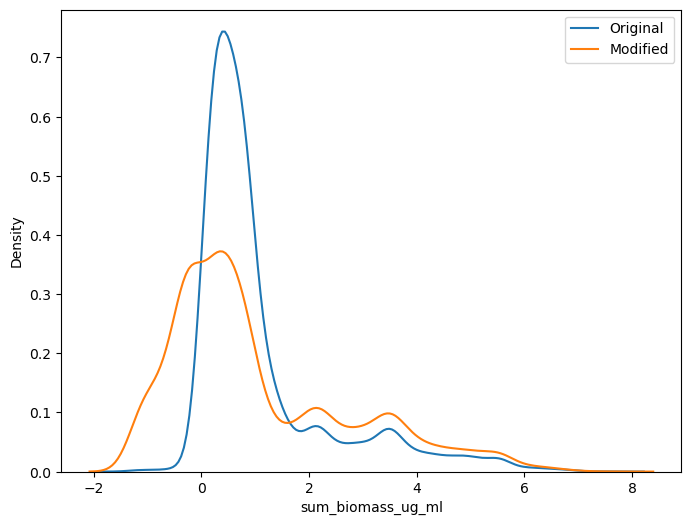

********Group 5************
(10386, 13)


r_index: 100%|#############################| 1119/1119 [00:01<00:00, 770.32it/s]


(11424, 13)


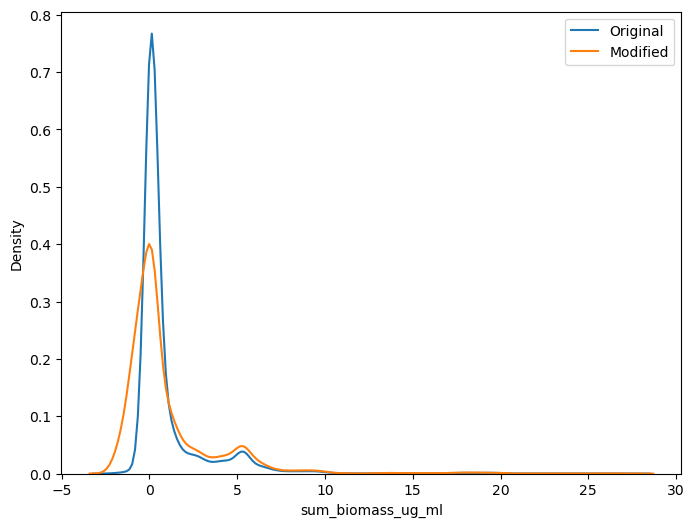

********Group 6************
(11053, 13)


r_index: 100%|###############################| 546/546 [00:00<00:00, 776.73it/s]


(12436, 13)


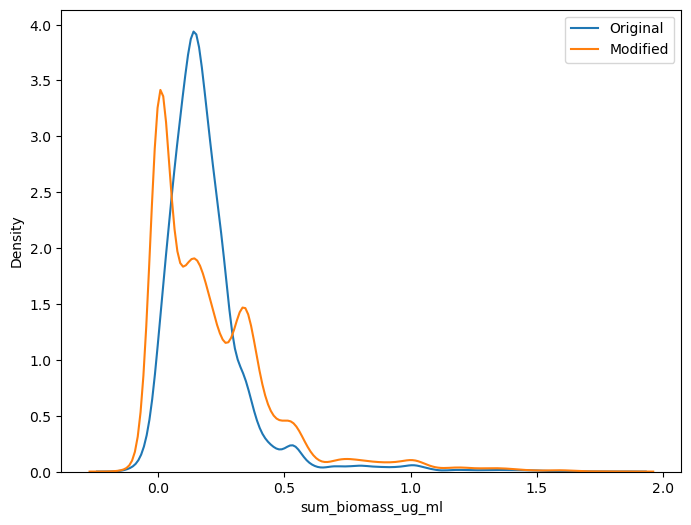

In [56]:
if do_smogn:
    orig_merged_train_smogn = []
    for group_num in orig_merged_train['group_num'].unique():
        group_df = orig_merged_train[orig_merged_train['group_num'] == group_num]
        print(f'********Group {group_num}************')
        print(group_df.shape)
        group_df_smogn = smogn.smoter(
            data = group_df.reset_index(drop=True),  ## pandas dataframe
            y = 'sum_biomass_ug_ml'  ## string ('header name')
        )
        print(group_df_smogn.shape)

        ## plot y distribution 
        plt.figure(figsize=(8, 6))
        seaborn.kdeplot(group_df['sum_biomass_ug_ml'], label = "Original")
        seaborn.kdeplot(group_df_smogn['sum_biomass_ug_ml'], label = "Modified")
        plt.legend()
        plt.show()

        orig_merged_train_smogn.append(group_df_smogn)


    orig_merged_train_smogn_concat = pd.concat(orig_merged_train_smogn, ignore_index=True)
    with open(smogn_file, 'wb') as f:
        pickle.dump(orig_merged_train_smogn_concat, f)
        
else:
    with open(smogn_file, 'rb') as f:
        orig_merged_train_smogn_concat = pickle.load(f)

In [59]:
regression_models_orig_smogn = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models_orig_smogn[model_name], _ = train(model_name, orig_merged_train_smogn_concat, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models_orig_smogn['lr'], _ = train('lr', orig_merged_train_smogn_concat, test_size=0.0, biomass_fn=np.log)

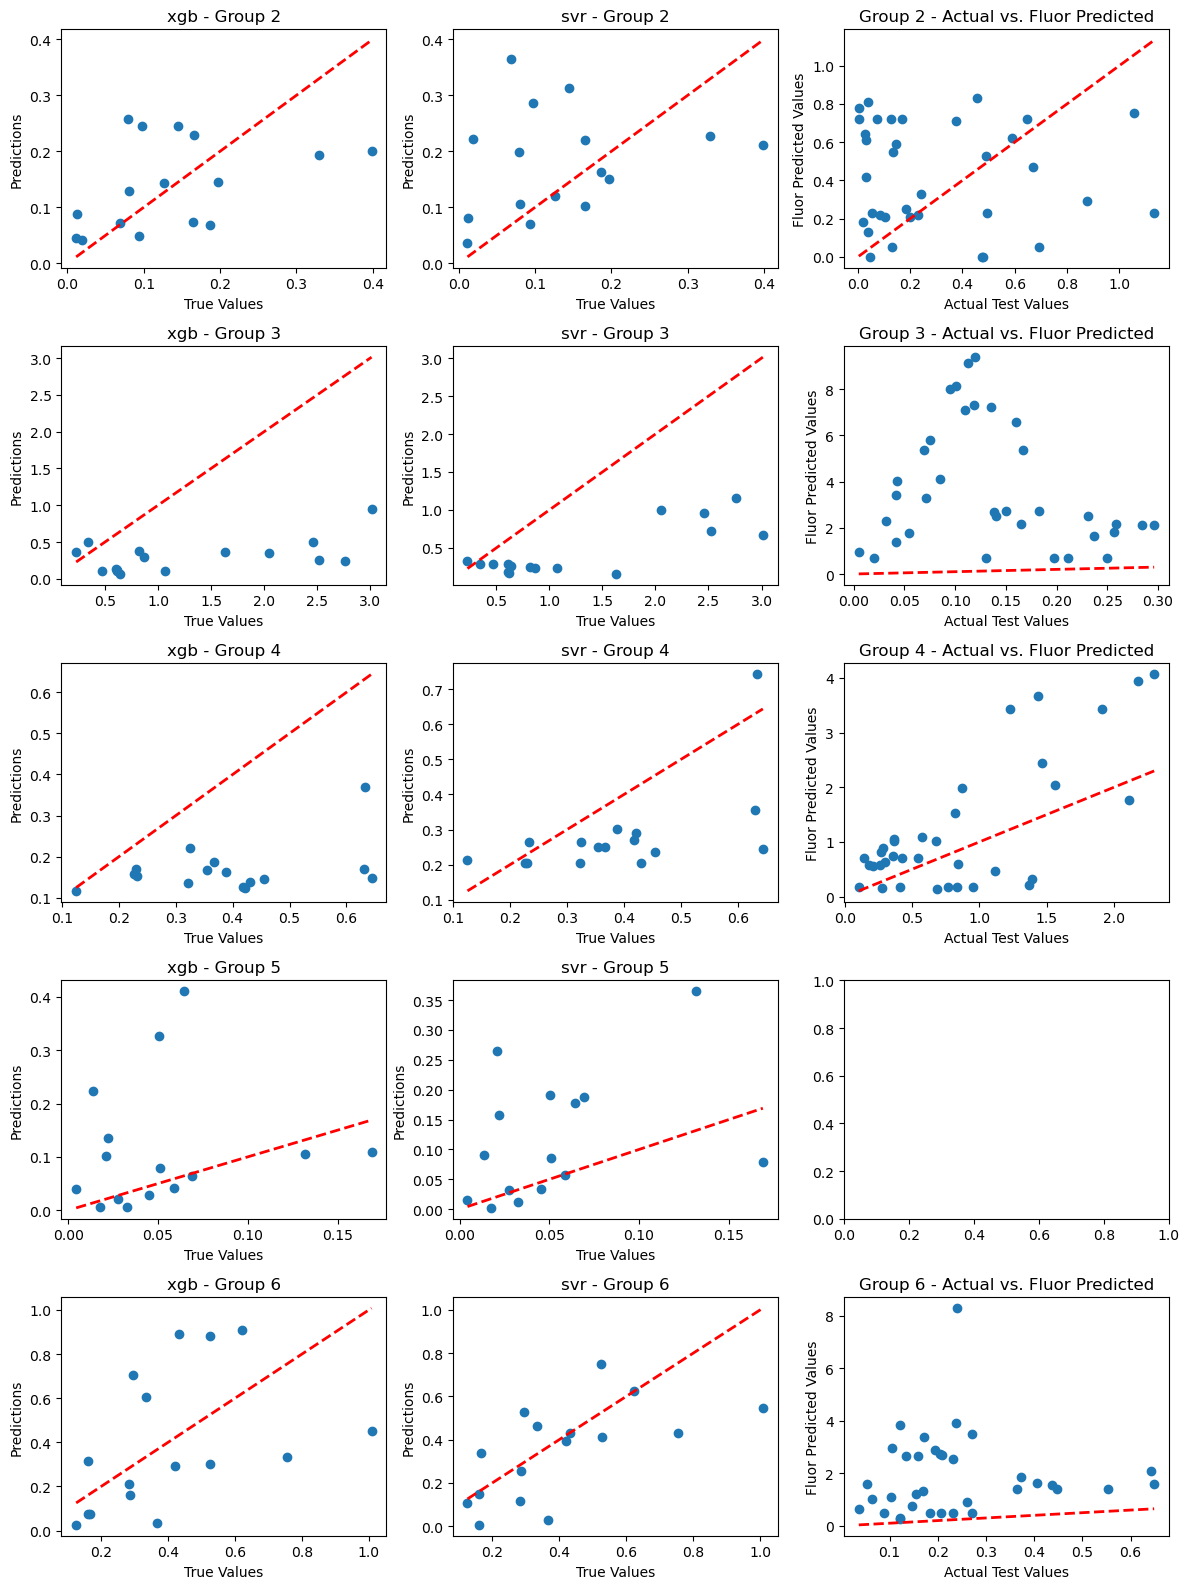

In [60]:
comparing_df_orig_smogn = compare_all_models(regression_models_orig_smogn, merged_val.drop(['year', 'Depth', 'week', 'month'], axis=1), fluor_test_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr'])

In [61]:
not_cleaned_smogn_res = compare_by_mpe(merged_val, regression_models_orig_smogn, predict_fn=np.exp)

# Compare All Methods

In [62]:
fp_res['Source'] = 'FP'
cleaned_res['Source'] = 'Cleaned'
cleaned_smogn_res['Source'] = 'Cleaned SMOGN'
not_cleaned_res['Source'] = 'Not Cleaned'
not_cleaned_smogn_res['Source'] = 'Not Cleaned SMOGN'

all_results = pd.concat([fp_res, cleaned_res, cleaned_smogn_res, not_cleaned_res, not_cleaned_smogn_res])
all_results

Model          2          3          4          6             Source  \
0    FP   7.292489  16.520820  10.004369   8.992688                 FP   
0   xgb   5.345828  24.649874  12.069362  10.882341            Cleaned   
1   svr   6.109543  23.714703   9.992070   6.829568            Cleaned   
2   elf   7.916731  40.980278  29.984425  10.426962            Cleaned   
3    lr   3.945039  40.915492  21.441185   7.976251            Cleaned   
0   xgb   6.176530  30.868779   9.617567  25.762598      Cleaned SMOGN   
1   svr   5.009404  19.646417   6.289790  12.420756      Cleaned SMOGN   
2   elf   6.265390  41.487583  24.781807  11.840332      Cleaned SMOGN   
3    lr   4.948935  38.241393   8.675365   6.890694      Cleaned SMOGN   
0   xgb   5.087548  23.057366   9.919594  16.249841        Not Cleaned   
1   svr   6.386435  24.467297  10.518729   7.427699        Not Cleaned   
2   elf   7.793360  41.087621  30.406158  10.443082        Not Cleaned   
3    lr   3.925578  41.062796  21.625474   8.871652        Not Cleaned   
0   xgb   7.308988  26.258792  10.022393  14.231214  Not Cleaned SMOGN   
1   svr   6.768006  21.415471   7.831283  10.407384  Not Cleaned SMOGN   
2   elf  11.334976  41.056854  27.046373  14.017906  Not Cleaned SMOGN   
3    lr   6.387670  39.334886  14.676578   5.406184  Not Cleaned SMOGN   

           5  
0        NaN  
0   5.061026  
1   5.835080  
2  12.539294  
3  15.517819  
0   6.452296  
1   4.657610  
2  23.575957  
3  32.601213  
0   4.262437  
1   5.730173  
2  12.462001  
3  15.593274  
0   7.575693  
1   5.387851  
2  16.983057  
3  23.531879

# Custom SMOGN

In [ ]:
k = 15
samp_method = 'extreme'
rel_thres = 0.9
rel_method = 'auto'
rel_xtrm_type = 'high'
rel_coef = 2.25

In [90]:
k = 15
samp_method = 'extreme'
rel_thres = 0.9
rel_method = 'auto'
rel_xtrm_type = 'high'
rel_coef = 1.5

arg_name = f"k_{k}_samp_meth_{samp_method}_rel_thres_{''.join(str(rel_thres).split('.'))}_rel_meth_{rel_method}_rel_x_t_{rel_xtrm_type}_rel_coef_{''.join(str(rel_coef).split('.'))}"
smogn_file = f'./data/smogn_{arg_name}.pkl'
do_smogn = not os.path.exists(smogn_file)

In [91]:
do_smogn = True

********Group 2************
(10391, 13)


r_index: 100%|###############################| 496/496 [00:00<00:00, 746.97it/s]


(18211, 13)


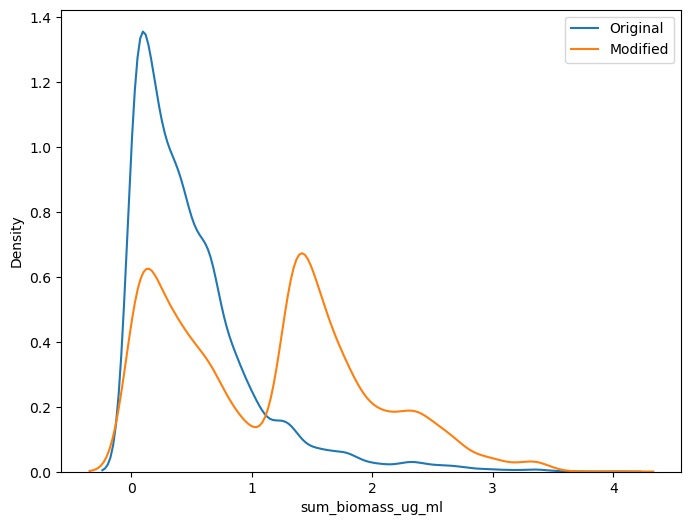

********Group 3************
(10755, 13)


r_index: 100%|###############################| 469/469 [00:00<00:00, 773.17it/s]


(18694, 13)


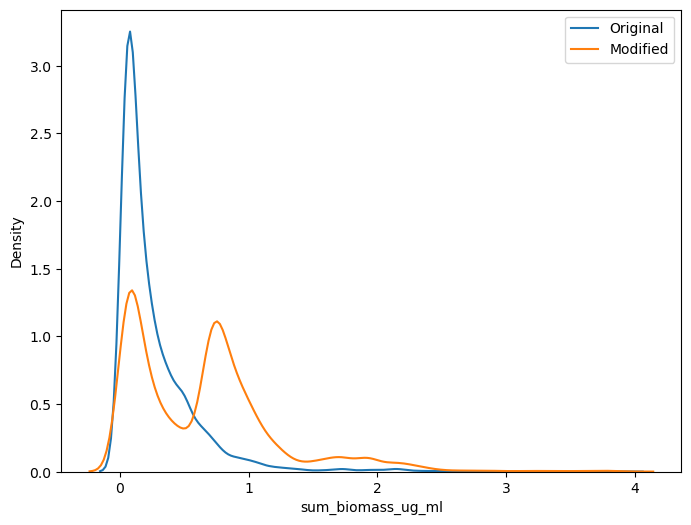

********Group 4************
(10955, 13)


r_index: 100%|###############################| 178/178 [00:00<00:00, 770.40it/s]


(16431, 13)


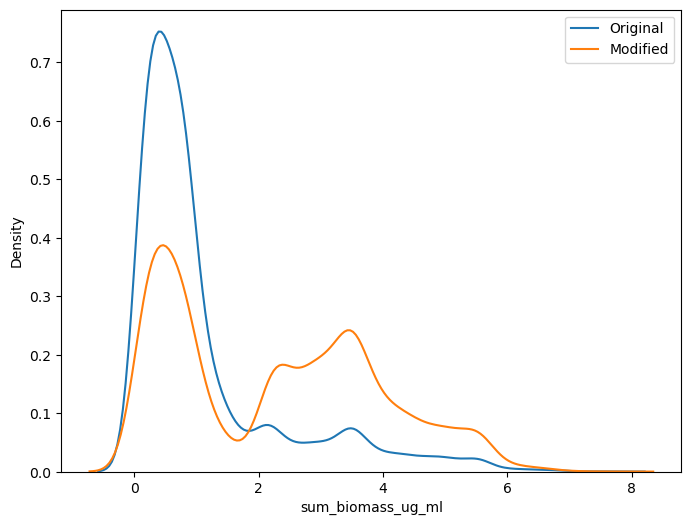

********Group 5************
(9687, 13)


r_index: 100%|#############################| 1037/1037 [00:01<00:00, 787.06it/s]


(14320, 13)


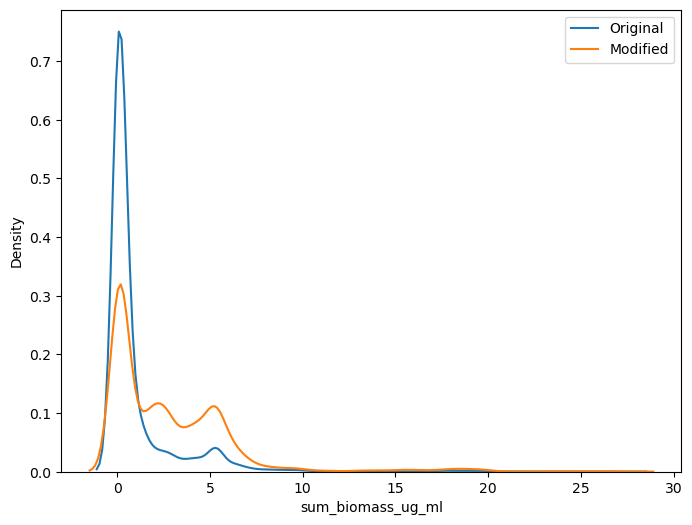

********Group 6************
(10580, 13)


synth_matrix: 100%|###########################| 755/755 [00:11<00:00, 66.68it/s]


(18658, 13)


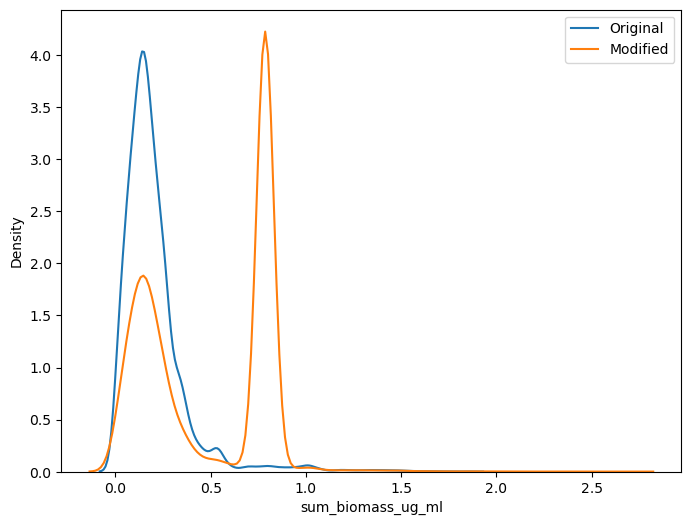

In [92]:
if do_smogn:
    merged_train_smogn = []
    for group_num in merged_train['group_num'].unique():
        group_df = merged_train[merged_train['group_num'] == group_num]
        print(f'********Group {group_num}************')
        print(group_df.shape)
        group_df_smogn = smogn.smoter(
            data = group_df.reset_index(drop=True),  ## pandas dataframe
            y = 'sum_biomass_ug_ml',  ## string ('header name')
            k=k,
            samp_method=samp_method,
            rel_thres=rel_thres,
            rel_method=rel_method,
            rel_xtrm_type=rel_xtrm_type,
            rel_coef=rel_coef
        )
        print(group_df_smogn.shape)

        ## plot y distribution 
        plt.figure(figsize=(8, 6))
        seaborn.kdeplot(group_df['sum_biomass_ug_ml'], label = "Original")
        seaborn.kdeplot(group_df_smogn['sum_biomass_ug_ml'], label = "Modified")
        plt.legend()
        plt.show()

        merged_train_smogn.append(group_df_smogn)


    merged_train_smogn_concat = pd.concat(merged_train_smogn, ignore_index=True)
    with open(smogn_file, 'wb') as f:
        pickle.dump(merged_train_smogn_concat, f)
        
else:
    with open(smogn_file, 'rb') as f:
        merged_train_smogn_concat = pickle.load(f)

In [93]:
regression_models_custom_smogn = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models_custom_smogn[model_name], _ = train(model_name, merged_train_smogn_concat, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models_custom_smogn['lr'], _ = train('lr', merged_train_smogn_concat, test_size=0.0, biomass_fn=np.log)

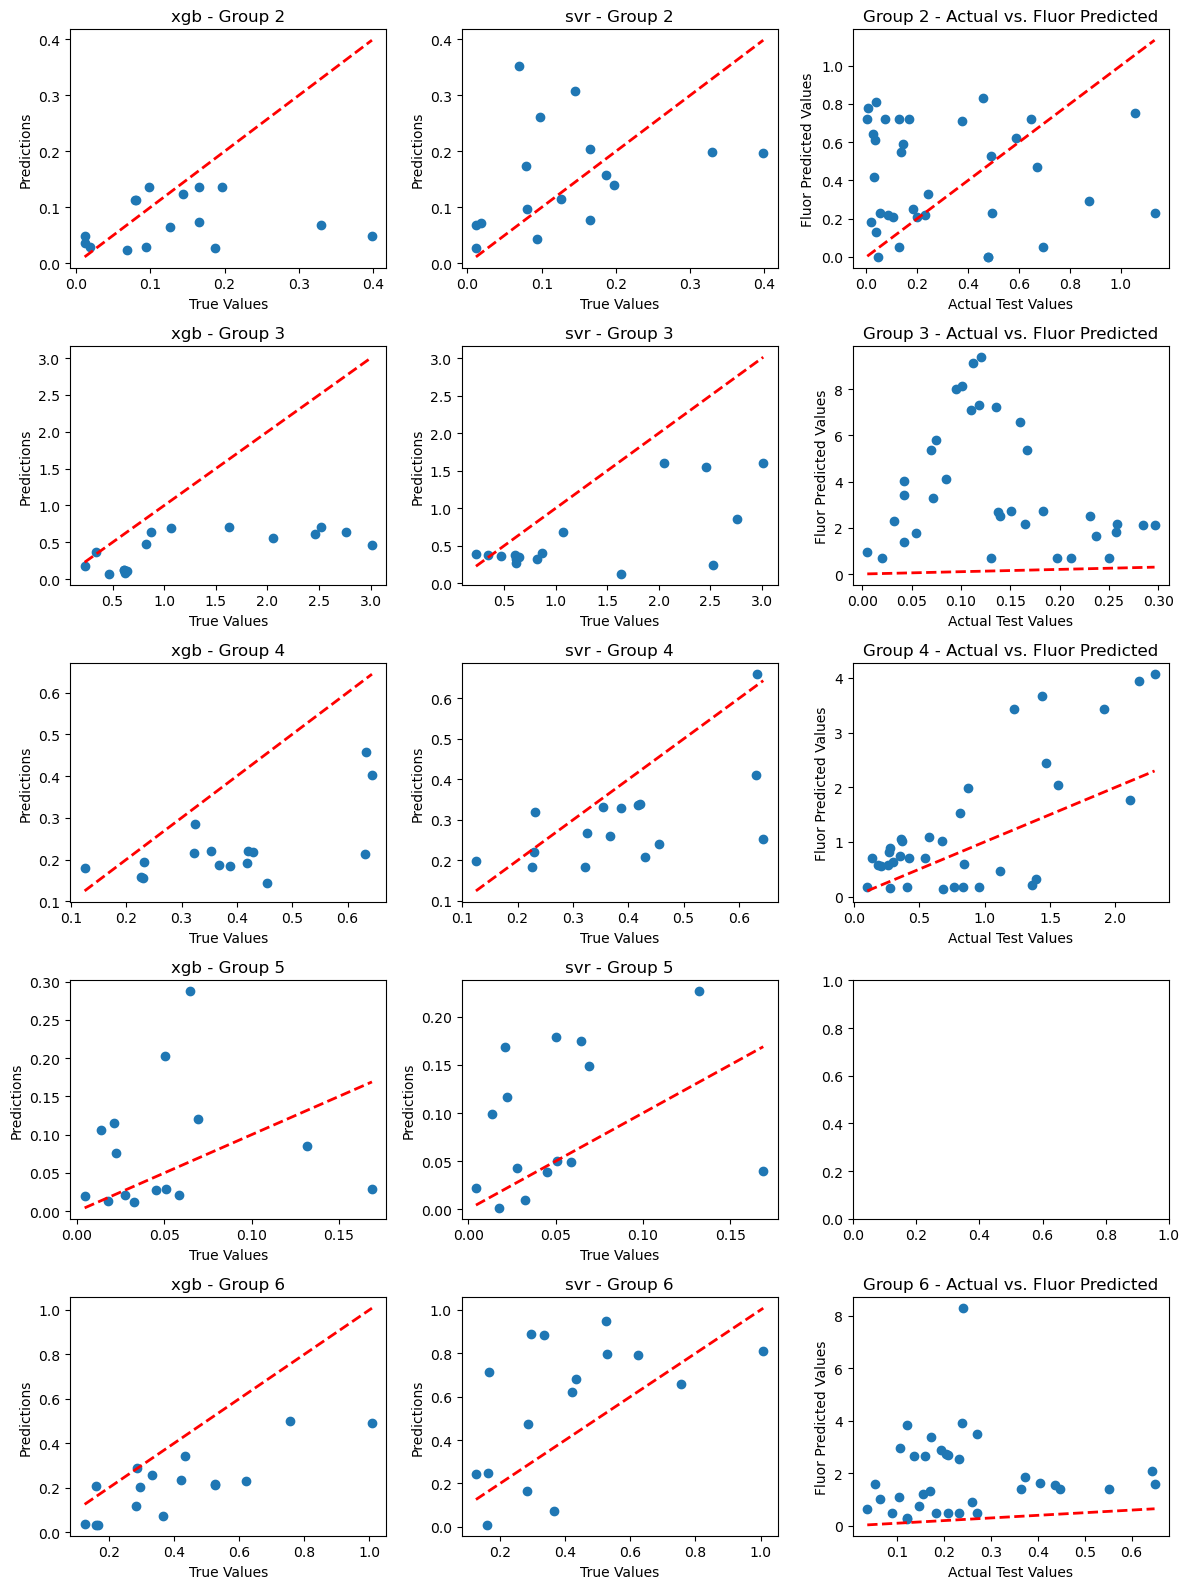

In [94]:
comparing_df_custom_smogn = compare_all_models(regression_models_custom_smogn, merged_val.drop(['year', 'Depth', 'week', 'month'], axis=1), fluor_test_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr'])

In [95]:
cleaned_custom_smogn_res = compare_by_mpe(merged_val, regression_models_custom_smogn, predict_fn=np.exp)

In [96]:
cleaned_custom_smogn_res['Source'] = 'Cleaned Custom SMOGN'

pd.concat([all_results, cleaned_custom_smogn_res])

Model          2          3          4          6                Source  \
0    FP   7.292489  16.520820  10.004369   8.992688                    FP   
0   xgb   5.345828  24.649874  12.069362  10.882341               Cleaned   
1   svr   6.109543  23.714703   9.992070   6.829568               Cleaned   
2   elf   7.916731  40.980278  29.984425  10.426962               Cleaned   
3    lr   3.945039  40.915492  21.441185   7.976251               Cleaned   
0   xgb   6.176530  30.868779   9.617567  25.762598         Cleaned SMOGN   
1   svr   5.009404  19.646417   6.289790  12.420756         Cleaned SMOGN   
2   elf   6.265390  41.487583  24.781807  11.840332         Cleaned SMOGN   
3    lr   4.948935  38.241393   8.675365   6.890694         Cleaned SMOGN   
0   xgb   5.087548  23.057366   9.919594  16.249841           Not Cleaned   
1   svr   6.386435  24.467297  10.518729   7.427699           Not Cleaned   
2   elf   7.793360  41.087621  30.406158  10.443082           Not Cleaned   
3    lr   3.925578  41.062796  21.625474   8.871652           Not Cleaned   
0   xgb   7.308988  26.258792  10.022393  14.231214     Not Cleaned SMOGN   
1   svr   6.768006  21.415471   7.831283  10.407384     Not Cleaned SMOGN   
2   elf  11.334976  41.056854  27.046373  14.017906     Not Cleaned SMOGN   
3    lr   6.387670  39.334886  14.676578   5.406184     Not Cleaned SMOGN   
0   xgb   4.894483  19.215243   7.751761   6.610485  Cleaned Custom SMOGN   
1   svr   5.103139  19.026405   7.302184  13.524644  Cleaned Custom SMOGN   
2   elf   5.673082  40.225057  23.655151  10.311663  Cleaned Custom SMOGN   
3    lr   4.732768  36.766188   8.770034   6.518623  Cleaned Custom SMOGN   

           5  
0        NaN  
0   5.061026  
1   5.835080  
2  12.539294  
3  15.517819  
0   6.452296  
1   4.657610  
2  23.575957  
3  32.601213  
0   4.262437  
1   5.730173  
2  12.462001  
3  15.593274  
0   7.575693  
1   5.387851  
2  16.983057  
3  23.531879  
0   5.442080  
1   3.431714  
2  22.138111  
3  29.950858